<a href="https://colab.research.google.com/github/Slautin/2024_Co-navigation/blob/main/1_Co_navigation_theory_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

April, 2024

Analysis codes for the article: **Bayesian co-navigation: Dynamic Designing of the Material Digital Twins via Active Learning**

* Author [Boris Slautin](https://scholar.google.com/citations?hl=ru&view_op=list_works&gmla=AH70aAU_JtxEIQgg_RTLPnUSZHKp1J1iDrJUxTZ7Dzw5p5jEtCEug5zMWLCh4A-pe5ekW_9a_aXHOSIjEp-2UT_kypL9DfD7GcD76qEpeOzSkAibBjmm_7RL&user=Y2AXABsAAAAJ)

* BEPS PFM  measurements are performed by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en)

* PTO thin film mas made by [Hiroshi Funakubo](https://scholar.google.co.jp/citations?user=12EJj9gAAAAJ&hl=en)

* [FerroSim](https://github.com/ramav87/FerroSim) lattice model codes from [Rama K. Vasudevan](https://scholar.google.com/citations?user=b2XP9A4AAAAJ&hl=en)

* [GPax](https://gpax.readthedocs.io/en/latest/) lib is developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)

* Idea and project leadership by [Sergei Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

In [1]:
!pip install sidpy
!pip install bglib
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git;
!pip install -q gpax
!pip install -e git+https://github.com/ramav87/FerroSim.git@rama-dev#egg=FerroSim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.8/210.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.6 MB/s eta 0:00:00
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.7-py3-none-any.whl size=21297 sha256=1c09b67d0ed62716e1da360d97478511732792f10c90f7a9e72d34b358efa255
  Stored in directory: /root/.cache/pip/wheels/ff/b2/88/174ead714f23773cc7563912e763404c814d705bf8eb7715d4
Successfully built numpy-groupies
  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-qxm_y3gn
  Ru

**Session must be restarted after ferrosim lib uploading**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

import pyUSID as usid
import h5py
import math

from atomai import utils
import torch
import gpax
import jax.numpy as jnp
import numpyro.distributions as dist
import numpyro

from typing import Dict
from itertools import product

from ferrosim import Ferro2DSim

/content/src/ferrosim/ferrosim/simclass.py:590: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)


Upload experimental data

In [2]:
!gdown https://drive.google.com/file/d/1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP
From (redirected): https://drive.google.com/uc?id=1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP&confirm=t&uuid=4a4aa29c-962d-495b-9d5d-4c0bcad410e5
To: /content/BEPS_1d7um_0009.h5
100% 3.04G/3.04G [00:25<00:00, 120MB/s]


In [3]:
#@title auxiliary functions
def correct_phase(phase, visualize=False):
  min_ = np.min(phase)
  max_ = np.max(phase)

  pha_correct = np.where(phase > 1.57, phase + (min_-max_), phase)
  pha_correct = pha_correct +np.pi - 0.75

  if visualize:
    plt.figure(figsize=(4,3))
    plt.hist(phase.ravel(), bins = 500, color='blue', label='before')
    plt.hist(pha_correct.reshape(-1),bins = 500, color='green', label='after');
    plt.axvline(np.pi, color ='red')
    plt.axvline(0, color ='red')
    plt.legend()

  return pha_correct

def shoelace_formula(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def get_area(loop_x, loop_y):
  x0, x1 = loop_x[: len(loop_x)//2], loop_x[len(loop_x)//2:]
  y0, y1 = loop_y[: len(loop_y)//2], loop_y[len(loop_y)//2:]
  p1 = np.abs(shoelace_formula(x0, y0))
  p2 = np.abs(shoelace_formula(x1, y1))
  return p1 + p2

def normalize(data):
  if np.ptp(data) == 0:
    return [np.min(data),np.ptp(data)], np.ones(data.shape)*0.5
  else:
    return [np.min(data),np.ptp(data)], (data - np.min(data))/(np.ptp(data))

In [4]:
#@title functions for saving data

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)
    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

# 1. Import experimental data

In [5]:
with h5py.File(r'/content/BEPS_1d7um_0009.h5', 'r+') as h5_BEPS1:

  sho_mat1 = h5_BEPS1['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']
  spec_val1 = h5_BEPS1['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values']
  pos_inds1 = h5_BEPS1['Measurement_000/Channel_000/Position_Indices']
  pos_dim_sizes1 = [np.max(pos_inds1[:,0])+1, np.max(pos_inds1[:,1]+1)]

  sho_mat_ndim1 = sho_mat1[:].reshape(pos_dim_sizes1[0], pos_dim_sizes1[1], -1)
  amp_mat_ndim1 = sho_mat_ndim1['Amplitude [V]']
  phase_mat_ndim1 = sho_mat_ndim1['Phase [rad]']
  spec_val1 = np.array(spec_val1)

  pha_correct = correct_phase(phase_mat_ndim1, visualize=False)

In [6]:
#split to cycles
cycles = 8

pr_mat_ndim1 = (amp_mat_ndim1*np.cos(pha_correct))*1E3
p_offfield1 = pr_mat_ndim1[:,:,1::2]
p_offfield1 = p_offfield1.reshape(*p_offfield1.shape[:-1],cycles,
                                p_offfield1.shape[-1]//cycles)

v_step1 = spec_val1[0, ::2]
v_step1 = v_step1.reshape(cycles, len(v_step1)//cycles)[0]

In [7]:
#averaging loops and crop initial scan for faster exploration
p_offfield1_av = p_offfield1[:,:,1:].mean(2)[:60,:60]

#ground truth areas
thresh = 0.05
areas = np.zeros((p_offfield1_av.shape[:-1]))

for i in range(p_offfield1_av.shape[0]):
  for j in range(p_offfield1_av.shape[1]):
    areas[i,j]  = get_area(v_step1,p_offfield1_av[i,j])

areas = areas

#structural image
st_im = p_offfield1[:,:,0,0][:60,:60]

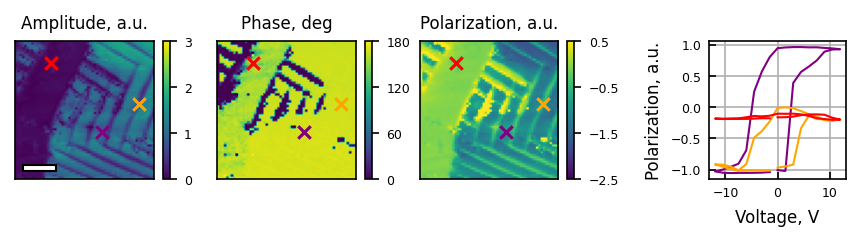

In [20]:
lc = [[37,20],[53,32],[15,50]]
lcolors = ['purple', 'orange', 'red']

origin = 0.05*st_im.shape[0], 0.05*st_im.shape[1]
length = len(st_im[0])/4.2
height = length/5

fig, ax = plt.subplots(1,4, figsize=(8,1.2), gridspec_kw={'width_ratios': [1.4, 1.4, 1.4, 2.5]}, dpi=150)
fig.subplots_adjust(wspace=0.1)

im = ax[0].imshow(amp_mat_ndim1[:60,:60,0]*1e3,
                  origin='lower', vmin=0, vmax=3)
ax[0].set_title('Amplitude, a.u.', fontsize=8)
ax[0].add_patch(patches.Rectangle(origin, length, height, color = 'white', ec='k', lw=1, fill = True))
cbar = plt.colorbar(im)
cbar.set_ticks([0, 1, 2, 3])
cbar.ax.tick_params(labelsize=6)

im = ax[1].imshow(pha_correct[:60,:60,0]/np.pi*180, vmin=0, vmax=180,
                  origin='lower')
ax[1].set_title('Phase, deg', fontsize=8)
cbar1 = plt.colorbar(im)
cbar1.set_ticks([0,60, 120, 180])
cbar1.ax.tick_params(labelsize=6)

im = ax[2].imshow(pr_mat_ndim1[:60,:60,0],
                  origin='lower', vmin=-2.5, vmax=0.5)
ax[2].set_title('Polarization, a.u.', fontsize=8)
cbar2 = plt.colorbar(im)
cbar2.set_ticks([-2.5,-1.5, -0.5, 0.5])
cbar2.ax.tick_params(labelsize=6)

for i,coord in enumerate(lc):
  ax[3].plot(v_step1, p_offfield1_av[coord[1], coord[0]], color=lcolors[i], lw=1)

ax[3].set_aspect(12)
ax[3].tick_params('both', direction='in', labelsize=6)
ax[3].grid()
ax[3].set_ylabel('Polarization, a.u.', fontsize=8)
ax[3].set_xlabel('Voltage, V', fontsize=8)

for _ in ax[:-1]:
  _.set_xticks([])
  _.set_yticks([])

  for i, coord in enumerate(lc):
    _.scatter(*coord, marker='x', color=lcolors[i])

# 2. Parameter space (E-loop)

In [8]:
#scalarizer
_, norm_area = normalize(areas)

#patch window size
ws = 12

#theshold to binarize
thresh = 0.45

#normalize
_, patch_image = normalize(st_im)

#bin_image
b_im = patch_image < thresh
b_im = b_im.astype(int)

#extract patches for each point on a grid
coordinates = utils.get_coord_grid(patch_image, 1)
pix = int(len(patch_image)+1-ws)

features_all, coords, _ = utils.extract_subimages(patch_image, coordinates, ws)
b_features_all, _, _ = utils.extract_subimages(b_im, coordinates, ws)

features_all = features_all[:,:,:,0]
b_features_all = b_features_all[:,:,:,0]

join_features = np.concatenate([features_all, b_features_all],axis=2)
f_scalarizer = norm_area[coords[:,0].astype(int), coords[:,1].astype(int)]

Text(0.5, 1.0, 'Binarized Structural image')

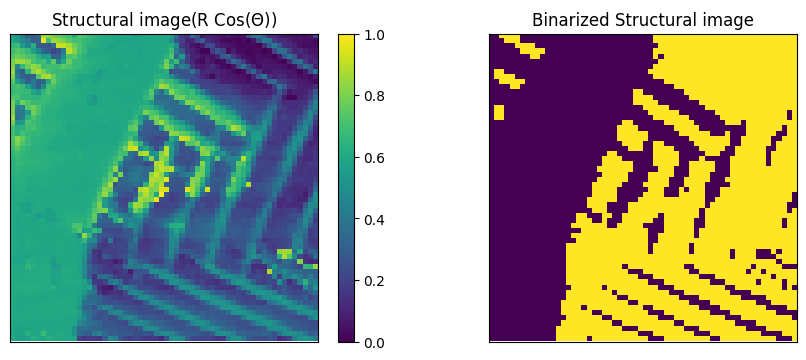

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1),
                       dpi=100)

dat = ax[0].imshow(patch_image, origin='lower',)
ax[0].set_title('Structural image(R Cos($\Theta$))')
cbar = fig.colorbar(dat, ax=ax[0])

ax[1].imshow(b_im, origin='lower',)
ax[1].set_title('Binarized Structural image')

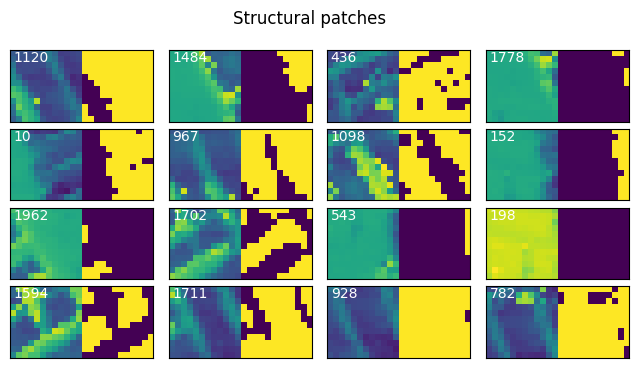

In [9]:
#plot examples of patches
fig, axes = plt.subplots(4, 4, figsize=(8, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(join_features))
    ax.imshow(join_features[i], interpolation='nearest')
    ax.text(0.1, 1.5, str(i), color='white')

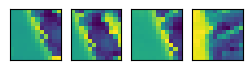

In [12]:
#for co-navigation scheme
random_elements = np.random.choice(np.arange(len(features_all)), 4, replace=False)
random_elements

fig, ax = plt.subplots(1, 4, figsize=(3,2))
ax[0].imshow(features_all[random_elements[0]])
ax[1].imshow(features_all[random_elements[1]])
ax[2].imshow(features_all[random_elements[2]])
ax[3].imshow(features_all[random_elements[3]])

for _ in ax:
  _.set_xticks([])
  _.set_yticks([])

# 3. Parameter space (T-loop)

The theoretical parameter space is derived from a large square, symbolizing the a-domain, and from periodically arranged narrow strip domains that depict the 'corrugation' domain structure.

Parameters:

**k** - the edge of the a-domain

**sf** - the distance between narrow 'corrugation' stripes

**ph** - the phase of 'corrugation' periodic structure

In [10]:
#@title theory parameter space functions
def a_domain(k, size=(12,12)):
  a_pattern = np.array([[1 if (i-k < j) else 0 for j in range(size[0])] for i in range(size[1])])
  return a_pattern.astype(bool)

def striped_pattern(stripe_frequency, phase, size=(12,12), stripe_width=2):
  pattern = np.zeros(size, dtype=int)

  for i in range(size[0]):
      for j in range(size[1]):
          if ((i + j) // stripe_width + phase) % stripe_frequency == 0:
              pattern[i, j] = 1

  return pattern.astype(bool)

def res_pattern(k, stripe_frequency, phase, size=(12,12)):
  res = a_domain(k, size=size) + striped_pattern(stripe_frequency, phase, size=size)
  return ~res

In [11]:
#coordinate system in theory latent space
coupling = np.arange(-12,13)
sf = np.arange(1,13)
ph = np.arange(0,12)

coords_th = np.array(list(product(coupling, sf, ph)))

[1809   81  770  163]


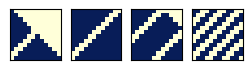

In [12]:
#for co-navigation scheme
random_elements = np.random.choice(np.arange(len(coords_th)), 4, replace=False)
print(random_elements)

fig, ax = plt.subplots(1, 4, figsize=(3,2))
ax[0].imshow(res_pattern(*coords_th[random_elements[0]]), cmap='YlGnBu')
ax[1].imshow(res_pattern(*coords_th[random_elements[1]]), cmap='YlGnBu')
ax[2].imshow(res_pattern(*coords_th[random_elements[2]]), cmap='YlGnBu')
ax[3].imshow(res_pattern(*coords_th[random_elements[3]]), cmap='YlGnBu')

for _ in ax:
  _.set_xticks([])
  _.set_yticks([])

# 4. Ferrosim

In [13]:
#@title FerroSim functions
def ferrosim_calc(patch,
                  gamma = 100,
                  defect_field = (30,0),
                  c_const = 5,
                  Eamp = (1E-9, 2),
                  time_vec_length = 2000,
                  dep_alpha = 1E-9):
  #tiem vec
  time_vec = np.linspace(0,2,time_vec_length)
  flat_patch = np.array(patch.flatten()).astype(bool)

  #defect field
  Efx, Efy = defect_field

  #coupling constant
  k = np.zeros(len(flat_patch))
  k[flat_patch==True] = c_const

  #depolarization constant
  #dep_alpha_distr = np.random.uniform(low = max(1e-3,dep_alpha-0.1), high = min(1, dep_alpha+0.1), size = ws*ws)

  #make defect list
  defect_list = np.ones((len(flat_patch),2))*1E-6
  defect_list[flat_patch==False] = (Efx, Efy)

  #applied field
  Evec_x = Eamp[0]*np.ones(len(time_vec))
  Evec_y = Eamp[1]*np.sin(2*np.pi*time_vec)
  applied_field = np.vstack((Evec_x, Evec_y)).T

  #initial P
  init_p  = np.random.uniform(low = -0.2, high = 0.2, size = (ws,ws,2))*1.0E-9

  sim = Ferro2DSim(n=ws,
                  time_vec = time_vec,
                  appliedE=applied_field,
                  defects=defect_list,
                  k=k,
                  dep_alpha = dep_alpha,
                  mode = 'tetragonal',
                  gamma=gamma,
                  initial_p = init_p)

  sim.runSim();

  return (applied_field.T, sim.results['Polarization'])

def plot_DKL_pred(mean, var, coords, seeds):
  fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=100)

  ax[0].scatter(coords[:,1],coords[:,0], c=mean, cmap='coolwarm', s=1)
  ax[0].set_aspect(1)
  ax[0].set_title('Prediction')
  ax[1].scatter(coords[:,1],coords[:,0], c=var, cmap='coolwarm', s=1)
  ax[1].set_aspect(1)
  ax[1].set_title('Uncertainty')

  for _ in ax:
    _.set_xlabel('$z_1$')
    _.set_ylabel('$z_2$')
    _.scatter(coords[seeds,1], coords[seeds,0], marker='x', color='black',
              s=10)

  return fig

from mpl_toolkits.mplot3d import Axes3D

def plot_DKL_pred3D(mean, var, coords, seeds):
    fig, ax = plt.subplots(1,2, figsize=(6,3), subplot_kw={'projection': '3d'})

    ax[0].scatter(coords[:,0],coords[:,1], coords[:,2], c=mean, cmap='coolwarm',
                  s=1, alpha=0.3)
    ax[0].set_aspect('auto')
    ax[0].set_title('Prediction')
    ax[1].scatter(coords[:,0],coords[:,1], coords[:,2], c=var, cmap='coolwarm',
                  s=1, alpha=0.3)
    ax[1].set_aspect('auto')
    ax[1].set_title('Uncertainty')

    for _ in ax:
      _.scatter(coords[seeds,0], coords[seeds,1], coords[seeds,2], marker='x',
                color='black',
                s=5)
    return fig

from typing import Union

# 5. Exploration

In [14]:
#object spaces


#theory
X          = torch.tensor(np.array([res_pattern(*x) for x in coords_th]))

#experiment
X_exp      = b_features_all
loop_exp   = p_offfield1_av
volt_exp   = v_step1
y_exp      = f_scalarizer
coords_exp = coords

#outer theory update object space
a_dep = np.linspace(0.001, 1, 50) #depolarization coef
coupl_coef = np.linspace(0.001, 1, 50) # K nearest neighbors coupling const
coord_adj = np.array(list(product(coupl_coef, a_dep)))

## Parameter space (outer loop)

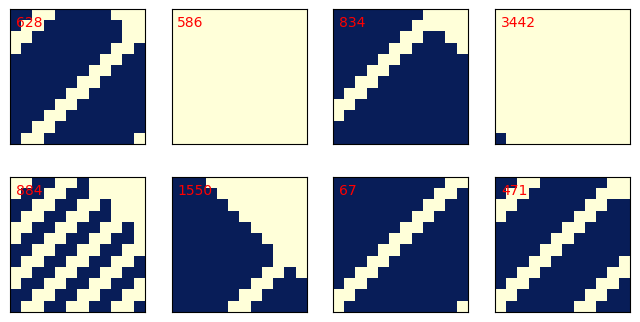

In [19]:
inds = np.random.randint(0,len(X), 8)

fig, ax = plt.subplots(2,4, figsize=(8,4))

for i,_ in enumerate(ax.flatten()):
  _.imshow(X[inds[i]].reshape(12,12),  cmap='YlGnBu',)
  _.set_xticks([])
  _.set_yticks([])
  _.text(0,1, s=str(inds[i]), c='red')

In [20]:
#wrapping ferrosim as the lambda function
lambda_y = lambda x, coupl, a_dep: ferrosim_calc(x,
                                                gamma = 100,
                                                defect_field = (30,0),
                                                c_const = 0.3,
                                                Eamp = (1E-9, 2),
                                                time_vec_length = 5000,
                                                dep_alpha = a_dep)

inds = [1465, 3162, 819, 1681]

loop_th_ex = []
for indd in inds:
  l = lambda_y(X[indd], 5, 0.3)
  loop_th_ex.append(l)

---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.33it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.26it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.79it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.05it/s]


Text(0.5, -0.15, 'Electric field, $E_c$')

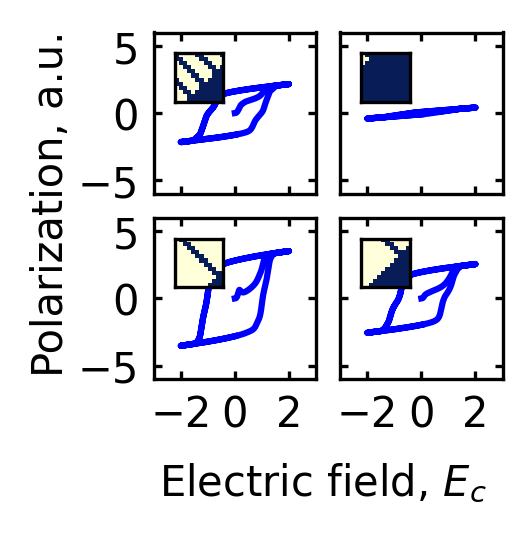

In [21]:
#fig for article
fig, ax = plt.subplots(2,2, figsize=(1.5,1.5), sharey=True, sharex=True, dpi=300)

fig.subplots_adjust(wspace=0.15, hspace=0.15)

for i, axx in enumerate(ax.flatten()):
  axx.plot(loop_th_ex[i][0][1], loop_th_ex[i][1][1]/10, lw=1.5, color='blue')
  axx.set_ylim(-6,6)
  axx.set_xlim(-3,3)
  axx.set_xticks([-2,0,2])

  axx.tick_params('both', direction='in', top=True, right=True)
  axx.tick_params(axis='both', which='both', length=2)

  axins = inset_axes(axx,
                     width="30%",  # width of inset axes
                     height="30%",  # height of inset axes
                     loc='upper left')
  axins.set_xticks([])
  axins.set_yticks([])
  im = axins.imshow(~X[inds[i]], cmap='YlGnBu',
                    interpolation='nearest',
                    vmin=0, vmax=1, origin='lower')

fig.text(-0.15, 0.5, 'Polarization, a.u.', va='center', rotation='vertical', fontsize=10)
fig.text(0.5, -0.15, 'Electric field, $E_c$', ha='center', fontsize=10)

([], [])

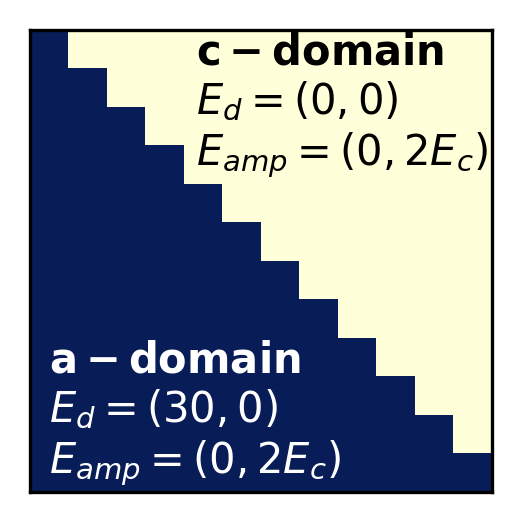

In [22]:
#for article
fig = plt.figure(figsize=(2,2), dpi=300)

plt.imshow(res_pattern(0,13,1), cmap='YlGnBu')
plt.text(0,11,'$\mathbf{a-domain}$\n$E_d = (30,0)$\n$E_{amp}=(0,2E_c$)', c='white', fontsize=10)
plt.text(3.8,3,'$\mathbf{c-domain}$\n$E_d = (0,0)$\n$E_{amp}=(0,2E_c$)', c='black', fontsize=10)

plt.xticks([])
plt.yticks([])

In [ ]:
#calculate manifold for the specific (ind) domain pattern
ind= 2000

lambda_y = lambda x, coupl, a_dep: ferrosim_calc(x,
                                                gamma = 100,
                                                defect_field = (30,0),
                                                c_const = coupl,
                                                Eamp = (1E-9, 2),
                                                time_vec_length = 5000,
                                                dep_alpha = a_dep)

loops = []
par = []

for a in np.linspace(1,0,4):
  for coup in np.linspace(0,1,4):
    print(a, coup)
    l = lambda_y(res_pattern(0,13,1), coup, a)
    loops.append(l)
    par.append((a, coup))

loop_ar = np.array(loops)

1.0 0.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 237.47it/s]


1.0 0.3333333333333333
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 239.03it/s]


1.0 0.6666666666666666
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 239.13it/s]


1.0 1.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 232.35it/s]


0.6666666666666667 0.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 237.88it/s]


0.6666666666666667 0.3333333333333333
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 237.08it/s]


0.6666666666666667 0.6666666666666666
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 238.41it/s]


0.6666666666666667 1.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 233.60it/s]


0.33333333333333337 0.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 238.85it/s]


0.33333333333333337 0.3333333333333333
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 239.83it/s]


0.33333333333333337 0.6666666666666666
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 233.80it/s]


0.33333333333333337 1.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 239.09it/s]


0.0 0.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 237.64it/s]


0.0 0.3333333333333333
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 238.90it/s]


0.0 0.6666666666666666
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:21<00:00, 234.10it/s]


0.0 1.0
---Performing simulation---


100%|██████████████████████████████████████| 4998/4998 [00:20<00:00, 239.16it/s]


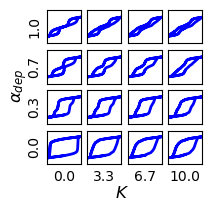

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(2,2), dpi=100)

fig.text(-0.06, 0.5, r'$\alpha_{dep}$', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, -0.06, r'$K$ ', ha='center', fontsize=12)

aa = np.linspace(1,0,4)
cc = np.linspace(0,10,4)
for i in range(4):
  ax[i,0].set_ylabel(str(round(aa[i],1)))

for i in range(4):
  ax[-1,i].set_xlabel(str(round(cc[i],1)))

for i,_ in enumerate(ax.flatten()):
  _.plot(loop_ar[i][0][1][len(loop_ar[i][0][1])//7:],
         loop_ar[i][1][1][len(loop_ar[i][0][1])//7:],
         lw=2, color='blue')
  _.set_xticks([])
  _.set_yticks([])
  _.set_ylim(-40,40)
  _.set_xlim(-2,2)

##Processing

In [15]:
#@title auxilary and visualization func
def sigmoid_decay(start, end, num_steps, a=1, b=0):
    """
    Generate a smooth decay sequence from start to end over num_steps using sigmoid function.

    Args:
    - start (float): Starting value.
    - end (float): Ending value.
    - num_steps (int): Number of steps in the decay sequence.
    - a (float): Slope parameter for sigmoid function.
    - b (float): Shift parameter for sigmoid function.

    Returns:
    - np.ndarray: Smooth decay sequence.
    """
    # Generate the decay sequence using sigmoid function
    x = np.linspace(-5, 5, num_steps)  # Adjust the range for the smoothness of the curve
    decay_sequence = 1 / (1 + np.exp(-a * (x - b)))

    # Scale and shift the decay sequence to fit the range [start, end]
    decay_sequence = start + (end - start) * decay_sequence

    return decay_sequence

def vis_seeds(seeds, X, loops_arrays, par):
  figsize = (3, len(seeds)//3+1)

  fig, ax = plt.subplots(figsize[1], figsize[0], figsize = (figsize[0]*2.2, figsize[1]*2))

  ax_list = ax.flatten()
  loops_arrays = np.array(loops_arrays)[:,:,1]

  for i in range(len(seeds)):
    loop = loops_arrays[i,:,loops_arrays.shape[-1]//2:]
    area = round(get_area(*loop),2)

    ax_list[i].plot(*loop)
    ax_list[i].set_title('Area {}'.format(area), fontsize=8)
    axins = inset_axes(ax_list[i],
                    width="35%",  # width of inset axes
                    height="35%",  # height of inset axes
                    loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X[seeds[i]], cmap='coolwarm',
                      interpolation='nearest', vmin=0, vmax=1)

  for _ in ax_list:
    _.set_ylim(-40, 40)
    _.set_xlim(-2.1, 2.1)
    _.set_xticks([])
    _.set_yticks([])

  fig.suptitle(f'Coupling coef. {round(par[0],2)}; Depolarization coef.  {round(par[1],2)}')
  plt.show()

def vis_seeds_exp(seeds, X, loops_arrays_y, loops_array_x, coords_exp):
  figsize = (3, len(seeds)//3+1)

  fig, ax = plt.subplots(figsize[1], figsize[0], figsize = (figsize[0]*2.2, figsize[1]*2))

  ax_list = ax.flatten()

  for i in range(len(seeds)):
    cd = coords_exp[seeds[i]].astype(int)
    loop = loop_exp[cd[0], cd[1]]
    area = round(get_area(loops_array_x, loop),2)

    ax_list[i].plot(loops_array_x, loop)
    ax_list[i].set_title('Area {}'.format(area), fontsize=8)
    axins = inset_axes(ax_list[i],
                    width="35%",  # width of inset axes
                    height="35%",  # height of inset axes
                    loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])

    x_im = X[seeds[i]]

    im = axins.imshow(x_im, cmap='coolwarm', interpolation='nearest', vmax=1, vmin=0)

  for _ in ax_list:
    _.set_ylim(-200, 200)
    _.set_xlim(-13, 13)
    _.set_xticks([])
    _.set_yticks([])

  plt.show()

def gt_grid(pattern):
  loops = []
  par = []
  ac = []
  a_list = np.linspace(0,1,3)
  coup_list = np.linspace(0.1,2,4)

  for a in a_list:
    for coup in coup_list:
      ac.append((a, coup))
      l = lambda_y(b_features_all[ind], coup, a)
      loops.append(l)
      par.append((a, coup))

  loop_ar = np.array(loops)[:,:,1]

  fig, ax = plt.subplots(3,4, figsize=(12,8))

  fig.text(0.04, 0.5, 'Depolarization constant', va='center', rotation='vertical')
  fig.text(0.5, 0.04, 'Coupling', va='center')

  for i,_ in enumerate(ax.flatten()):
    _.plot(*loop_ar[i])
    _.set_xticks([])
    _.set_yticks([])
    _.set_ylim(-40,40)
    _.set_xlim(-2,2)
    _.set_title('c = {}, a = {}'.format(round(ac[i][1],2),
                                        round(ac[i][0], 2)))


def plot_model_adj(X_tr, X_test, f_pred, f_var, acq):
  next_seed = int(np.argmax(acq))

  fig, ax = plt.subplots(1,3, figsize=(11,3))
  ax[0].scatter(X_test[:,0], X_test[:,1], c=f_pred, cmap='coolwarm')
  ax[0].set_title('Predicted MSE')
  ax[1].scatter(X_test[:,0], X_test[:,1], c=f_var, cmap='coolwarm')
  ax[1].set_title('Uncertainty MSE')
  ax[2].scatter(X_test[:,0], X_test[:,1], c=acq, cmap='coolwarm')
  ax[2].set_title('UCB')

  for _ in ax:
    _.set_aspect(1)
    _.set_xlabel(r'$K$')
    _.set_ylabel(r'$\alpha_{dep}$')
    _.scatter(X_tr[:,0], X_tr[:,1], c='black', marker='x')

  ax[2].scatter(X_test[next_seed,0], X_test[next_seed,1],
                c='lightgreen', marker='o', s=50)

  plt.show()
  return fig

In [16]:
#@title Co-navigation functions
def seeds_theory(X, n=5, adj_p = (0.1, 0.1)):
  seeds = np.random.choice(np.arange(len(X)), n, replace=False)

  X_train = X[seeds]
  model_res = [lambda_y(xx, adj_p[0]*10, adj_p[1]) for xx in X_train]

  X_train_dkl = X_train.reshape(len(X_train), -1)
  y_train     = np.array([get_area(xx[0][1, len(xx[0])//2:], xx[1][1, len(xx[0])//2:]) for xx in model_res])
  _, y_train_dkl = normalize(y_train)
  return seeds, X_train_dkl, y_train_dkl, y_train, model_res

def seeds_exp(X, loops_arrays, volt_exp, coords_exp, n=5):
  seeds_exp = np.random.choice(np.arange(len(X)), n, replace=False)
  y_train_exp = []
  for i in range(len(seeds_exp)):
    cd = coords_exp[seeds_exp[i]].astype(int)
    loop = loop_exp[cd[0], cd[1]]
    area = get_area(volt_exp, loop)
    y_train_exp.append(area)

  X_train_exp = torch.tensor(X[seeds_exp])
  return seeds_exp, X_train_exp, y_train_exp

def iteration_theory(seeds, X, X_train_dkl, y_train, coords, adj_p, mem_tail, visualise=False):

  X_train_dkl = X_train_dkl.reshape(len(X_train_dkl), -1)
  if len(X_train_dkl) > mem_tail:
    X_train_dkl_short = X_train_dkl[-mem_tail:]
    y_train_short = y_train[-mem_tail:]
  else:
    X_train_dkl_short = X_train_dkl
    y_train_short = y_train

  data_dim = X_train_dkl_short.shape[-1]
  _, y_train_dkl_short = normalize(y_train_short)

  key1, key2 = gpax.utils.get_keys()
  dklgp = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')

  dklgp.fit(key1, X_train_dkl_short, y_train_dkl_short)

  mean, var = dklgp.predict(key2, X.reshape(len(X), -1))

  acq = gpax.acquisition.UE(key2, dklgp, X.reshape(len(X), -1),
                            recent_points=X_train_dkl_short, penalty='delta')

  next_point_idx = var.argmax()

  #plot results
  if visualise:
    if coords.shape[-1] == 3:
      fig = plot_DKL_pred3D(mean, var, coords, seeds)
      axx = fig.get_axes()[1]
      axx.scatter(coords[next_point_idx,0],
                  coords[next_point_idx,1],
                  coords[next_point_idx,2],
                  color='lightgreen', edgecolors='black', s=15)
      plt.show()

    elif coords.shape[-1] == 2:
      fig = plot_DKL_pred(mean, var, coords, seeds=seeds)
      axx = fig.get_axes()

      for _ in axx:
        _.set_xlabel('')
        _.set_ylabel('')

      axx[1].scatter(coords[next_point_idx,1],
                    coords[next_point_idx,0],
                    color='lightgreen', edgecolors='black', s=15)
      plt.show()


  seeds = np.append(seeds, next_point_idx)
  X_next = X[next_point_idx]
  X_train_dkl = X[seeds]

  m_next = lambda_y(X_next, adj_p[0]*10, adj_p[1])

  y_train_next = get_area(m_next[0][1, len(m_next[0])//2:], m_next[1][1, len(m_next[0])//2:])
  y_train = np.append(y_train, y_train_next)

  #plot loop
  if visualise:
    fig,ax = plt.subplots(figsize=(3,2.5))
    plt.plot(m_next[0][1, len(m_next[0])//2:], m_next[1][1, len(m_next[0])//2:], c='black')
    axins = inset_axes(ax,
                      width="35%",  # width of inset axes
                      height="35%",  # height of inset axes
                      loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X[next_point_idx], cmap='coolwarm',
                      interpolation='nearest',
                      vmin=0, vmax=1)

    plt.title(f'Coupling {round(adj_p[0]*10,2)}, Depolarization const {round(adj_p[1],2)}, area {round(y_train_next,2)}')
    plt.show()

  return seeds, X_train_dkl, y_train, np.array([mean, var]), dklgp

def iteration_exp(seeds, X_exp, y_exp, volt_exp, coords, visualize=False):
  X_train_exp = X_exp[seeds]
  y_train = y_exp.reshape(-1, y_exp.shape[-1])[seeds]
  y_train_exp = np.array(list([get_area(volt_exp, x) for x in y_train]))
  data_dim = X_train_exp.shape[-1]

  key1, key2 = gpax.utils.get_keys()
  dklgp = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
  _, y_train_exp_dkl = normalize(y_train_exp)
  dklgp.fit(key1, X_train_exp, y_train_exp_dkl)
  mean, var = dklgp.predict(key2, X_exp, batch_size=128)

  acq = gpax.acquisition.UE(key2, dklgp, X_exp,
                            recent_points=X_train_exp, penalty='delta', penalty_factor=0.01)

  next_point_idx = acq.argmax()
  print(next_point_idx)

  if visualise:
    fig = plot_DKL_pred(mean, var, coords, seeds=seeds)
    axx = fig.get_axes()
    for _ in axx:
      _.set_xlabel('')
      _.set_ylabel('')

    axx[1].scatter(coords[next_point_idx,1],
                coords[next_point_idx,0],
                color='lightgreen', edgecolors='black', s=15)
    plt.show()

  seeds = np.append(seeds, next_point_idx)
  X_next = X_exp[next_point_idx]

  cd = coords[next_point_idx].astype(int)
  y_next = get_area(volt_exp, y_exp[cd[0],cd[1]])


  #plot loop
  if visualise:
    fig,ax = plt.subplots(figsize=(3,2.5))
    plt.plot(volt_exp, y_exp[cd[0],cd[1]], c='black')
    axins = inset_axes(ax,
                      width="35%",  # width of inset axes
                      height="35%",  # height of inset axes
                      loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X_next.reshape(int(data_dim**0.5), int(data_dim**0.5)),
                      cmap='coolwarm',
                      interpolation='nearest',
                      vmin=0, vmax=1,
                      origin='lower')

    plt.title(f'Area {round(y_next,2)}')
    plt.show()

  X_train_exp = X_exp[seeds]
  y_train_exp = np.append(y_train_exp, y_next)

  return seeds, X_train_exp, y_train_exp, np.array([mean, var]), dklgp


def model_adjust_iteration(seed_model, mse_error, X_test, mem_tail, beta=0.1,
                           lengthscale_prior_dist=None, structural=False):

  if len(mse_error) > mem_tail:
    y_model = mse_error[-mem_tail:]
    X_tr = X_test[seed_model][-mem_tail:]
  else:
    y_model = mse_error
    X_tr = X_test[seed_model]

  if len(X_tr)>50:
    recent_points = X_tr[-50:]
  else:
    recent_points = X_tr

  def mean_function(x):
    return np.max(y_model)
  print(np.max(y_model))
  def parabolic(x: jnp.ndarray,  params: Dict[str, float]) -> jnp.ndarray:
    return jnp.array([params['alpha']*(x[:,0] - params["x0"])**2
            + params['beta']*(x[:,1] - params["y0"])**2])

  def parabolic_priors():
    # Sample model parameters
    alpha = numpyro.sample("alpha", dist.HalfNormal(10))
    beta  = numpyro.sample("beta", dist.HalfNormal(10))
    x0    = numpyro.sample("x0", dist.Uniform(0,1))
    y0    = numpyro.sample("y0", dist.Uniform(0,1))
    # Return sampled parameters as a dictionary
    return {"alpha": alpha, "beta": beta, "x0": x0, "y0": y0}


  key1, key2 = gpax.utils.get_keys(1)
  if structural:
    gp_model = gpax.viGP(input_dim=2,
                        kernel='RBF',
                        guide='delta',
                        lengthscale_prior_dist=lengthscale_prior_dist,
                        mean_fn=parabolic,
                        mean_fn_prior = parabolic_priors,
                        noise_prior_dist = None,)
  else:
    gp_model = gpax.viGP(input_dim=2,
                        kernel='RBF',
                        guide='delta',
                        lengthscale_prior_dist=lengthscale_prior_dist,
                        mean_fn= mean_function,
                        noise_prior_dist = None,)

  gp_model.fit(key1, X_tr, y_model, num_steps=250, step_size=0.05)

  ei = gpax.acquisition.UCB(key2, gp_model, X_test, maximize=False, beta=beta)
  print(max(ei), min(ei))
  f_pred, f_var = gp_model.predict(key2, X_test)

  next_seed = int(np.argmax(ei))

  plot_model_adj(X_tr, X_test, f_pred, f_var, ei)

  return next_seed, np.array([f_pred, f_var, np.array(ei)]), gp_model.get_samples()


----------------- Seed points theory -----------------

---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.78it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.95it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.97it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.96it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.98it/s]



----------------- Seed points exp. -----------------

---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.20it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.30it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.75it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.59it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.88it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.39it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.72it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.91it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.28it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.69it/s]



----------------- Iteration exp. 0 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 356.77it/s, init loss: 13175.0137, avg. loss [951-1000]: 12472.1916]



Inferred GP kernel parameters
k_length         [0.3234     0.36789998]
k_scale          0.45859998
noise            0.0229
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.19it/s]



----------------- Iteration theory 0 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 401.64it/s, init loss: 13169.6973, avg. loss [951-1000]: 12475.1101]



Inferred GP kernel parameters
k_length         [0.3202     0.36789998]
k_scale          0.4112
noise            0.098
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.12it/s]



----------------- Iteration exp. 1 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 370.29it/s, init loss: 13176.1826, avg. loss [951-1000]: 12471.2846]



Inferred GP kernel parameters
k_length         [0.32299998 0.36789998]
k_scale          0.4655
noise            0.0195
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.25it/s]



----------------- Iteration theory 1 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 557.53it/s, init loss: 13169.7207, avg. loss [951-1000]: 12475.0681]



Inferred GP kernel parameters
k_length         [0.3283     0.36789998]
k_scale          0.40969998
noise            0.098799996
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.82it/s]



----------------- Iteration exp. 2 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 366.18it/s, init loss: 13177.4004, avg. loss [951-1000]: 12470.2324]



Inferred GP kernel parameters
k_length         [0.3279     0.36789998]
k_scale          0.468
noise            0.0179
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.74it/s]



----------------- Iteration theory 2 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 542.19it/s, init loss: 13169.6045, avg. loss [951-1000]: 12475.1435]



Inferred GP kernel parameters
k_length         [0.3272     0.36789998]
k_scale          0.3994
noise            0.0998
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.73it/s]



----------------- Iteration exp. 3 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 321.85it/s, init loss: 13178.5693, avg. loss [951-1000]: 12469.2547]



Inferred GP kernel parameters
k_length         [0.32549998 0.36789998]
k_scale          0.47329998
noise            0.0158
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.58it/s]



----------------- Iteration theory 3 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 545.71it/s, init loss: 13169.3867, avg. loss [951-1000]: 12474.9794]



Inferred GP kernel parameters
k_length         [0.32979998 0.36789998]
k_scale          0.3708
noise            0.106199995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.47it/s]



----------------- Iteration exp. 4 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 356.85it/s, init loss: 13179.8066, avg. loss [951-1000]: 12467.8334]



Inferred GP kernel parameters
k_length         [0.3129     0.36789998]
k_scale          0.4865
noise            0.0139999995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.90it/s]



----------------- Iteration theory 4 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 551.80it/s, init loss: 13169.3350, avg. loss [951-1000]: 12474.9548]



Inferred GP kernel parameters
k_length         [0.3302     0.36789998]
k_scale          0.36929998
noise            0.1074
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.69it/s]



----------------- Iteration exp. 5 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 358.92it/s, init loss: 13181.0264, avg. loss [951-1000]: 12466.5765]



Inferred GP kernel parameters
k_length         [0.3177 0.368 ]
k_scale          0.49339998
noise            0.0131
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.94it/s]



----------------- Iteration theory 5 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 551.98it/s, init loss: 13169.1699, avg. loss [951-1000]: 12475.1490]



Inferred GP kernel parameters
k_length         [0.3251     0.36789998]
k_scale          0.41189998
noise            0.0933
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.05it/s]



----------------- Theory model tune iter_5 -----------------

MSE 1.39

----------------- Iteration exp. 6 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 377.42it/s, init loss: 13182.2188, avg. loss [951-1000]: 12465.1777]



Inferred GP kernel parameters
k_length         [0.30949998 0.36789998]
k_scale          0.4983
noise            0.0121
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.41it/s]



----------------- Iteration theory 6 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 547.77it/s, init loss: 13169.3164, avg. loss [951-1000]: 12475.1461]



Inferred GP kernel parameters
k_length         [0.3285     0.36789998]
k_scale          0.4186
noise            0.0973
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.13it/s]



----------------- Iteration exp. 7 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 295.91it/s, init loss: 13183.4307, avg. loss [951-1000]: 12465.0415]



Inferred GP kernel parameters
k_length         [0.3442 0.368 ]
k_scale          0.46829998
noise            0.0126
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.95it/s]



----------------- Iteration theory 7 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 534.09it/s, init loss: 13169.3164, avg. loss [951-1000]: 12475.1462]



Inferred GP kernel parameters
k_length         [0.3286     0.36789998]
k_scale          0.4186
noise            0.0973
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.28it/s]



----------------- Iteration exp. 8 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 300.53it/s, init loss: 13184.6201, avg. loss [951-1000]: 12465.0429]



Inferred GP kernel parameters
k_length         [0.32619998 0.36789998]
k_scale          0.46949998
noise            0.011
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.29it/s]



----------------- Iteration theory 8 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 536.77it/s, init loss: 13169.1250, avg. loss [951-1000]: 12475.2102]



Inferred GP kernel parameters
k_length         [0.3286     0.36789998]
k_scale          0.41419998
noise            0.099
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.22it/s]



----------------- Iteration exp. 9 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 296.38it/s, init loss: 13185.7754, avg. loss [951-1000]: 12461.1280]



Inferred GP kernel parameters
k_length         [0.3035     0.36789998]
k_scale          0.5135
noise            0.0099
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.06it/s]



----------------- Iteration theory 9 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 548.60it/s, init loss: 13169.0195, avg. loss [951-1000]: 12475.0411]



Inferred GP kernel parameters
k_length         [0.3283     0.36789998]
k_scale          0.3595
noise            0.1099
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.63it/s]



----------------- Iteration exp. 10 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 293.59it/s, init loss: 13187.0449, avg. loss [951-1000]: 12460.8241]



Inferred GP kernel parameters
k_length         [0.34489998 0.3714    ]
k_scale          0.4746
noise            0.011
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.93it/s]



----------------- Iteration theory 10 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 554.43it/s, init loss: 13169.0957, avg. loss [951-1000]: 12475.2043]



Inferred GP kernel parameters
k_length         [0.326      0.36789998]
k_scale          0.4136
noise            0.0973
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.41it/s]



----------------- Theory model tune iter_10 -----------------

MSE 1.43

----------------- Iteration exp. 11 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 294.33it/s, init loss: 13188.0996, avg. loss [951-1000]: 12458.5666]



Inferred GP kernel parameters
k_length         [0.3105     0.36789998]
k_scale          0.505
noise            0.0095999995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.02it/s]



----------------- Iteration theory 11 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 449.87it/s, init loss: 13169.2949, avg. loss [951-1000]: 12475.0896]



Inferred GP kernel parameters
k_length         [0.3208     0.36789998]
k_scale          0.40489998
noise            0.089499995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.16it/s]



----------------- Iteration exp. 12 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 298.71it/s, init loss: 13189.1152, avg. loss [951-1000]: 12459.4440]



Inferred GP kernel parameters
k_length         [0.3464     0.36789998]
k_scale          0.4712
noise            0.0095
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.55it/s]



----------------- Iteration theory 12 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 537.79it/s, init loss: 13169.4736, avg. loss [951-1000]: 12475.1262]



Inferred GP kernel parameters
k_length         [0.3152     0.36789998]
k_scale          0.4066
noise            0.0894
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.06it/s]



----------------- Iteration exp. 13 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 300.06it/s, init loss: 13190.0342, avg. loss [951-1000]: 12456.6216]



Inferred GP kernel parameters
k_length         [0.3358 0.3678]
k_scale          0.50339997
noise            0.0093
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.78it/s]



----------------- Iteration theory 13 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 545.92it/s, init loss: 13169.4971, avg. loss [951-1000]: 12475.1481]



Inferred GP kernel parameters
k_length         [0.322      0.36789998]
k_scale          0.4199
noise            0.093399994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.06it/s]



----------------- Iteration exp. 14 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 291.30it/s, init loss: 13191.0684, avg. loss [951-1000]: 12454.6137]



Inferred GP kernel parameters
k_length         [0.30449998 0.36789998]
k_scale          0.5169
noise            0.008599999
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 124.98it/s]



----------------- Iteration theory 14 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 435.42it/s, init loss: 13169.5850, avg. loss [951-1000]: 12475.0803]



Inferred GP kernel parameters
k_length         [0.3217     0.36789998]
k_scale          0.3906
noise            0.0973
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.08it/s]



----------------- Iteration exp. 15 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 274.01it/s, init loss: 13191.8555, avg. loss [951-1000]: 12454.6799]



Inferred GP kernel parameters
k_length         [0.3691     0.36789998]
k_scale          0.42459998
noise            0.0088
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.32it/s]



----------------- Iteration theory 15 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.03it/s, init loss: 13169.4893, avg. loss [951-1000]: 12475.0068]



Inferred GP kernel parameters
k_length         [0.32529998 0.36789998]
k_scale          0.3755
noise            0.105399996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.62it/s]



----------------- Theory model tune iter_15 -----------------

MSE 1.44
UCB beta =  99.984
1.4358128607273102


100%|██████████| 250/250 [00:00<00:00, 372.84it/s, init loss: 4.4961, avg. loss [229-240]: 1.3547]



Inferred GP parameters
k_length         [0.20009999 0.20199999]
k_scale          0.1741
noise            0.1739
4.4628167 3.6548476


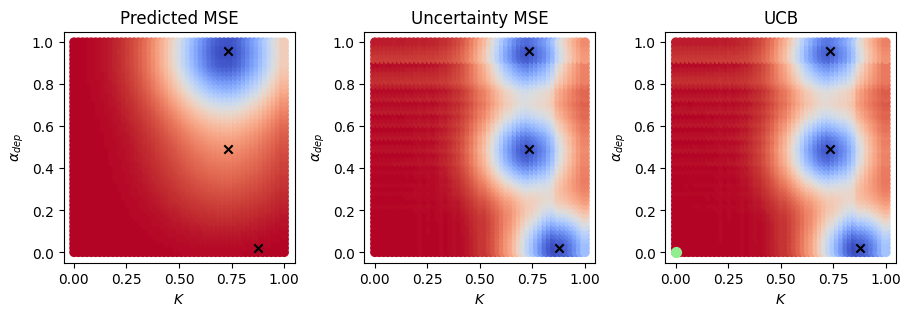


----------------- Iteration exp. 16 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 289.12it/s, init loss: 13193.1064, avg. loss [951-1000]: 12455.6783]



Inferred GP kernel parameters
k_length         [0.35169998 0.36789998]
k_scale          0.428
noise            0.0084999995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.66it/s]



----------------- Iteration theory 16 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 537.69it/s, init loss: 13169.5703, avg. loss [951-1000]: 12475.0633]



Inferred GP kernel parameters
k_length         [0.32209998 0.36789998]
k_scale          0.38549998
noise            0.1012
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.74it/s]



----------------- Iteration exp. 17 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 257.01it/s, init loss: 13194.2266, avg. loss [951-1000]: 12456.6156]



Inferred GP kernel parameters
k_length         [0.4331 0.4112]
k_scale          0.38099998
noise            0.0089
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.44it/s]



----------------- Iteration theory 17 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.46it/s, init loss: 13169.2109, avg. loss [951-1000]: 12475.2723]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2681
noise            0.2164
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.59it/s]



----------------- Iteration exp. 18 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 279.38it/s, init loss: 13195.3184, avg. loss [951-1000]: 12452.2620]



Inferred GP kernel parameters
k_length         [0.3311 0.3595]
k_scale          0.4421
noise            0.0084
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.12it/s]



----------------- Iteration theory 18 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 536.87it/s, init loss: 13169.0312, avg. loss [951-1000]: 12475.3465]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2654
noise            0.22369999
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.01it/s]



----------------- Iteration exp. 19 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 282.96it/s, init loss: 13196.3311, avg. loss [951-1000]: 12447.0543]



Inferred GP kernel parameters
k_length         [0.3125     0.36789998]
k_scale          0.52599996
noise            0.0075999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.72it/s]



----------------- Iteration theory 19 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 534.56it/s, init loss: 13169.0312, avg. loss [951-1000]: 12475.3463]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2654
noise            0.22369999
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.59it/s]



----------------- Iteration exp. 20 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 282.64it/s, init loss: 13197.5098, avg. loss [951-1000]: 12445.8267]



Inferred GP kernel parameters
k_length         [0.315      0.36789998]
k_scale          0.5233
noise            0.0077
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.94it/s]



----------------- Iteration theory 20 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 445.10it/s, init loss: 13168.7793, avg. loss [951-1000]: 12475.3854]



Inferred GP kernel parameters
k_length         [0.3353     0.36789998]
k_scale          0.2694
noise            0.1875
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.31it/s]



----------------- Theory model tune iter_20 -----------------

MSE 1.4
UCB beta =  99.945
1.4358128607273102


100%|██████████| 250/250 [00:00<00:00, 380.68it/s, init loss: 5.6253, avg. loss [229-240]: 1.6856]



Inferred GP parameters
k_length         [0.20009999 0.20199999]
k_scale          0.1358
noise            0.1356
3.7720428 3.0591335


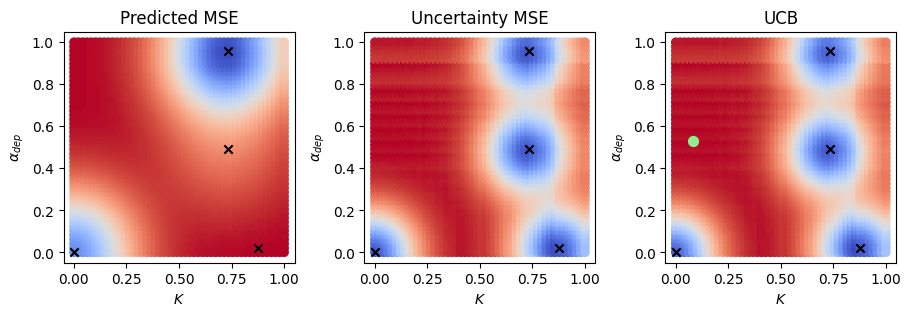


----------------- Iteration exp. 21 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 279.94it/s, init loss: 13198.7051, avg. loss [951-1000]: 12446.2704]



Inferred GP kernel parameters
k_length         [0.3301     0.36789998]
k_scale          0.49929997
noise            0.0078
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.52it/s]



----------------- Iteration theory 21 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 533.97it/s, init loss: 13168.8164, avg. loss [951-1000]: 12475.0827]



Inferred GP kernel parameters
k_length         [0.32009998 0.36789998]
k_scale          0.4094
noise            0.087799996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.26it/s]



----------------- Iteration exp. 22 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 298.83it/s, init loss: 13199.8457, avg. loss [951-1000]: 12442.5372]



Inferred GP kernel parameters
k_length         [0.3069 0.3624]
k_scale          0.5361
noise            0.0074
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.70it/s]



----------------- Iteration theory 22 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 546.88it/s, init loss: 13168.9209, avg. loss [951-1000]: 12474.9141]



Inferred GP kernel parameters
k_length         [0.3251     0.36789998]
k_scale          0.3698
noise            0.102699995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.49it/s]



----------------- Iteration exp. 23 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 223.70it/s, init loss: 13200.9365, avg. loss [951-1000]: 12441.8383]



Inferred GP kernel parameters
k_length         [0.33179998 0.3732    ]
k_scale          0.49589998
noise            0.0075
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.94it/s]



----------------- Iteration theory 23 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 533.64it/s, init loss: 13168.9883, avg. loss [951-1000]: 12475.0946]



Inferred GP kernel parameters
k_length         [0.3299     0.36789998]
k_scale          0.3179
noise            0.1349
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.71it/s]



----------------- Iteration exp. 24 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 226.56it/s, init loss: 13201.9111, avg. loss [951-1000]: 12442.4963]



Inferred GP kernel parameters
k_length         [0.32999998 0.368     ]
k_scale          0.46719998
noise            0.0075999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.82it/s]



----------------- Iteration theory 24 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 539.14it/s, init loss: 13168.9219, avg. loss [951-1000]: 12475.0383]



Inferred GP kernel parameters
k_length         [0.3335     0.36789998]
k_scale          0.31559998
noise            0.1407
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.73it/s]



----------------- Iteration exp. 25 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 217.29it/s, init loss: 13203.0391, avg. loss [951-1000]: 12443.8751]



Inferred GP kernel parameters
k_length         [0.3558 0.3698]
k_scale          0.42229998
noise            0.0078
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.42it/s]



----------------- Iteration theory 25 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 550.45it/s, init loss: 13168.9219, avg. loss [951-1000]: 12475.0386]



Inferred GP kernel parameters
k_length         [0.33339998 0.36789998]
k_scale          0.3157
noise            0.1407
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.28it/s]



----------------- Theory model tune iter_25 -----------------

MSE 1.49
UCB beta =  99.807
1.486242562532425


100%|██████████| 250/250 [00:00<00:00, 354.27it/s, init loss: 6.7193, avg. loss [229-240]: 1.9325]



Inferred GP parameters
k_length         [0.20009999 0.20359999]
k_scale          0.1081
noise            0.10789999
3.153284 2.5342495


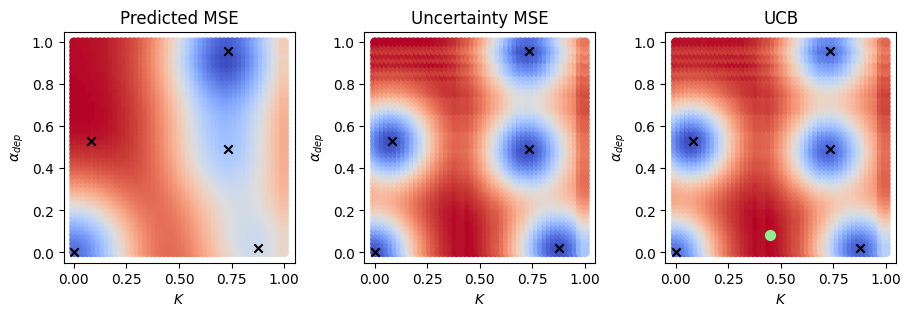


----------------- Iteration exp. 26 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 225.91it/s, init loss: 13204.0127, avg. loss [951-1000]: 12438.3109]



Inferred GP kernel parameters
k_length         [0.32369998 0.36789998]
k_scale          0.49069998
noise            0.0072999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.94it/s]



----------------- Iteration theory 26 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 538.11it/s, init loss: 13169.1299, avg. loss [951-1000]: 12475.2045]



Inferred GP kernel parameters
k_length         [0.3296     0.36789998]
k_scale          0.4145
noise            0.0989
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.55it/s]



----------------- Iteration exp. 27 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 198.01it/s, init loss: 13205.0986, avg. loss [951-1000]: 12438.4347]



Inferred GP kernel parameters
k_length         [0.3425 0.3295]
k_scale          0.4229
noise            0.0075999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.48it/s]



----------------- Iteration theory 27 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 545.56it/s, init loss: 13168.8252, avg. loss [951-1000]: 12475.3624]



Inferred GP kernel parameters
k_length         [0.3225     0.36789998]
k_scale          0.3615
noise            0.1281
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.06it/s]



----------------- Iteration exp. 28 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 226.75it/s, init loss: 13206.1533, avg. loss [951-1000]: 12436.7020]



Inferred GP kernel parameters
k_length         [0.3326 0.3671]
k_scale          0.42659998
noise            0.0074
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.23it/s]



----------------- Iteration theory 28 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 545.17it/s, init loss: 13168.9746, avg. loss [951-1000]: 12475.0613]



Inferred GP kernel parameters
k_length         [0.32479998 0.36789998]
k_scale          0.325
noise            0.12329999
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.39it/s]



----------------- Iteration exp. 29 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 216.14it/s, init loss: 13207.0928, avg. loss [951-1000]: 12434.8835]



Inferred GP kernel parameters
k_length         [0.3168 0.2961]
k_scale          0.40489998
noise            0.0069999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.79it/s]



----------------- Iteration theory 29 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 551.81it/s, init loss: 13169.3105, avg. loss [951-1000]: 12474.9963]



Inferred GP kernel parameters
k_length         [0.3274     0.36789998]
k_scale          0.3721
noise            0.1039
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.55it/s]



----------------- Iteration exp. 30 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.17it/s, init loss: 13208.0898, avg. loss [951-1000]: 12432.4474]



Inferred GP kernel parameters
k_length         [0.3238 0.3681]
k_scale          0.5038
noise            0.0069
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.62it/s]



----------------- Iteration theory 30 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 533.01it/s, init loss: 13169.4023, avg. loss [951-1000]: 12475.1429]



Inferred GP kernel parameters
k_length         [0.3279     0.36789998]
k_scale          0.4182
noise            0.0976
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.00it/s]



----------------- Theory model tune iter_30 -----------------

MSE 1.44
UCB beta =  99.331
1.486242562532425


100%|██████████| 250/250 [00:00<00:00, 350.65it/s, init loss: 7.7442, avg. loss [229-240]: 2.0255]



Inferred GP parameters
k_length         [0.2061 0.2051]
k_scale          0.085
noise            0.0846
2.6132097 2.0669909


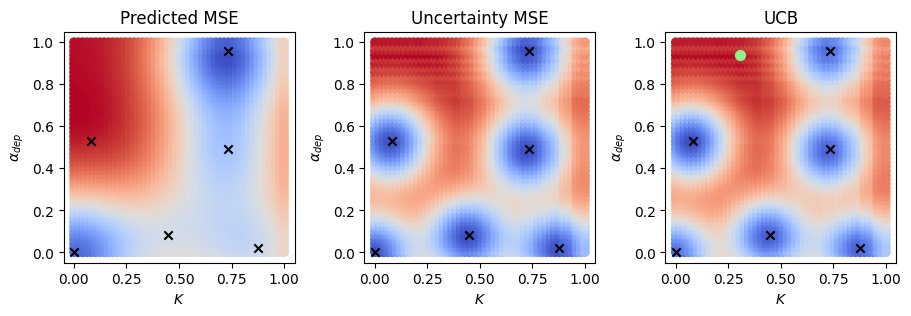


----------------- Iteration exp. 31 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 212.50it/s, init loss: 13209.2041, avg. loss [951-1000]: 12447.3131]



Inferred GP kernel parameters
k_length         [0.54539996 0.55399996]
k_scale          0.2762
noise            0.0075999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.55it/s]



----------------- Iteration theory 31 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 542.23it/s, init loss: 13169.4023, avg. loss [951-1000]: 12475.1428]



Inferred GP kernel parameters
k_length         [0.3281     0.36789998]
k_scale          0.4181
noise            0.0976
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.83it/s]



----------------- Iteration exp. 32 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 225.19it/s, init loss: 13210.2666, avg. loss [951-1000]: 12431.1579]



Inferred GP kernel parameters
k_length         [0.3119     0.37489998]
k_scale          0.45639998
noise            0.0069
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.22it/s]



----------------- Iteration theory 32 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.05it/s, init loss: 13169.3105, avg. loss [951-1000]: 12474.9964]



Inferred GP kernel parameters
k_length         [0.3274     0.36789998]
k_scale          0.3721
noise            0.1039
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.15it/s]



----------------- Iteration exp. 33 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 218.42it/s, init loss: 13211.4102, avg. loss [951-1000]: 12432.0321]



Inferred GP kernel parameters
k_length         [0.34939998 0.3278    ]
k_scale          0.4877
noise            0.0071
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.02it/s]



----------------- Iteration theory 33 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 534.93it/s, init loss: 13169.1484, avg. loss [951-1000]: 12475.0088]



Inferred GP kernel parameters
k_length         [0.32529998 0.36789998]
k_scale          0.3637
noise            0.1019
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.42it/s]



----------------- Iteration exp. 34 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 212.74it/s, init loss: 13212.3750, avg. loss [951-1000]: 12429.1843]



Inferred GP kernel parameters
k_length         [0.3471 0.3743]
k_scale          0.42639998
noise            0.0069
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 125.45it/s]



----------------- Iteration theory 34 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 537.18it/s, init loss: 13169.0127, avg. loss [951-1000]: 12475.0179]



Inferred GP kernel parameters
k_length         [0.32569999 0.36789998]
k_scale          0.37269998
noise            0.0998
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.70it/s]



----------------- Iteration exp. 35 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 216.07it/s, init loss: 13213.5107, avg. loss [951-1000]: 12427.2564]



Inferred GP kernel parameters
k_length         [0.3021     0.36789998]
k_scale          0.47219998
noise            0.0067
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.87it/s]



----------------- Iteration theory 35 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.42it/s, init loss: 13169.2881, avg. loss [951-1000]: 12474.9793]



Inferred GP kernel parameters
k_length         [0.32979998 0.36789998]
k_scale          0.3714
noise            0.105799995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.47it/s]



----------------- Theory model tune iter_35 -----------------

MSE 1.62
UCB beta =  97.702
1.6183224320411682


100%|██████████| 250/250 [00:00<00:00, 340.61it/s, init loss: 8.8334, avg. loss [229-240]: 2.5627]



Inferred GP parameters
k_length         [0.2439 0.2499]
k_scale          0.086399995
noise            0.0822
2.360292 1.8710976


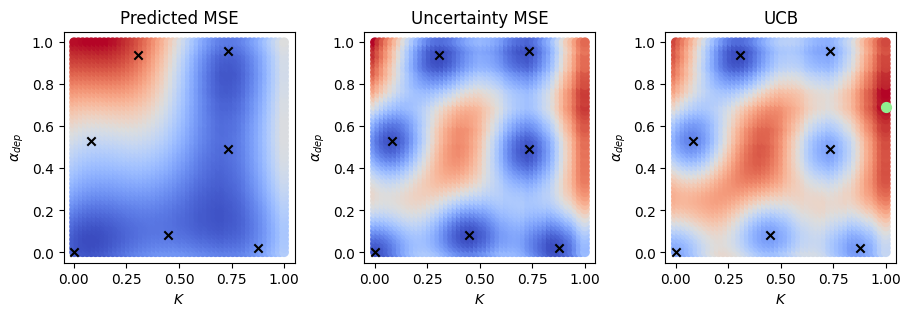


----------------- Iteration exp. 36 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 216.60it/s, init loss: 13214.5156, avg. loss [951-1000]: 12424.0900]



Inferred GP kernel parameters
k_length         [0.3143 0.3378]
k_scale          0.4649
noise            0.0067
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.33it/s]



----------------- Iteration theory 36 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.02it/s, init loss: 13169.4580, avg. loss [951-1000]: 12475.0828]



Inferred GP kernel parameters
k_length         [0.32999998 0.36789998]
k_scale          0.41
noise            0.0981
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.24it/s]



----------------- Iteration exp. 37 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 214.39it/s, init loss: 13215.4873, avg. loss [951-1000]: 12425.0537]



Inferred GP kernel parameters
k_length         [0.2841 0.3626]
k_scale          0.48709998
noise            0.0067
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.62it/s]



----------------- Iteration theory 37 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.32it/s, init loss: 13169.4580, avg. loss [951-1000]: 12475.0831]



Inferred GP kernel parameters
k_length         [0.32979998 0.36789998]
k_scale          0.41
noise            0.0981
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.91it/s]



----------------- Iteration exp. 38 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 228.03it/s, init loss: 13216.6191, avg. loss [951-1000]: 12427.0375]



Inferred GP kernel parameters
k_length         [0.3102 0.3708]
k_scale          0.48499998
noise            0.0069999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.45it/s]



----------------- Iteration theory 38 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 393.99it/s, init loss: 13169.2744, avg. loss [951-1000]: 12474.9722]



Inferred GP kernel parameters
k_length         [0.32979998 0.36789998]
k_scale          0.3708
noise            0.1063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.94it/s]



----------------- Iteration exp. 39 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 215.62it/s, init loss: 13217.7627, avg. loss [951-1000]: 12419.4453]



Inferred GP kernel parameters
k_length         [0.2985     0.36789998]
k_scale          0.5419
noise            0.0064999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.43it/s]



----------------- Iteration theory 39 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.05it/s, init loss: 13169.0801, avg. loss [951-1000]: 12475.0535]



Inferred GP kernel parameters
k_length         [0.327      0.36789998]
k_scale          0.32279998
noise            0.124699995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.76it/s]



----------------- Iteration exp. 40 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 216.66it/s, init loss: 13218.7227, avg. loss [951-1000]: 12414.9584]



Inferred GP kernel parameters
k_length         [0.2837 0.3615]
k_scale          0.5737
noise            0.0063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.57it/s]



----------------- Iteration theory 40 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 538.02it/s, init loss: 13168.7246, avg. loss [951-1000]: 12475.0412]



Inferred GP kernel parameters
k_length         [0.3241     0.36789998]
k_scale          0.3198
noise            0.1215
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.52it/s]



----------------- Theory model tune iter_40 -----------------

MSE 1.6
UCB beta =  92.414
1.6183224320411682


100%|██████████| 250/250 [00:00<00:00, 357.67it/s, init loss: 9.8677, avg. loss [229-240]: 2.5110]



Inferred GP parameters
k_length         [0.2769 0.2825]
k_scale          0.0727
noise            0.065299995
1.7941681 1.4070787


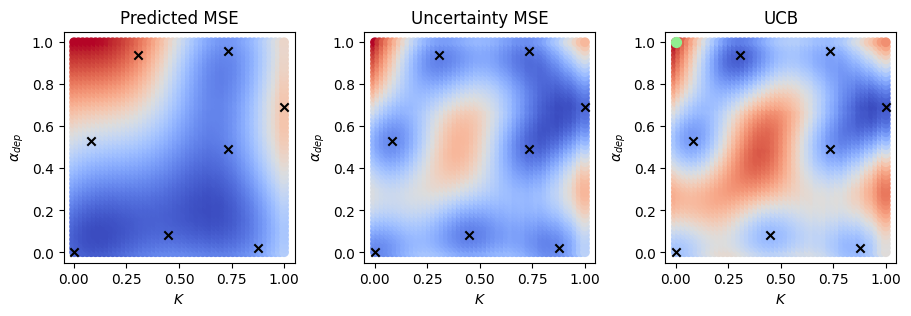


----------------- Iteration exp. 41 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.95it/s, init loss: 13219.8877, avg. loss [951-1000]: 12417.4760]



Inferred GP kernel parameters
k_length         [0.2784 0.3604]
k_scale          0.5051
noise            0.0066
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.75it/s]



----------------- Iteration theory 41 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 530.47it/s, init loss: 13168.8164, avg. loss [951-1000]: 12474.8784]



Inferred GP kernel parameters
k_length         [0.3217     0.36789998]
k_scale          0.3708
noise            0.099199995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.83it/s]



----------------- Iteration exp. 42 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 230.03it/s, init loss: 13220.9531, avg. loss [951-1000]: 12415.5797]



Inferred GP kernel parameters
k_length         [0.36929998 0.3595    ]
k_scale          0.4511
noise            0.0064999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.73it/s]



----------------- Iteration theory 42 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 388.30it/s, init loss: 13169.2168, avg. loss [951-1000]: 12475.0226]



Inferred GP kernel parameters
k_length         [0.31919998 0.36789998]
k_scale          0.3647
noise            0.1034
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.98it/s]



----------------- Iteration exp. 43 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 222.64it/s, init loss: 13222.1367, avg. loss [951-1000]: 12414.6071]



Inferred GP kernel parameters
k_length         [0.2652 0.3549]
k_scale          0.4998
noise            0.0064999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.51it/s]



----------------- Iteration theory 43 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.07it/s, init loss: 13169.6123, avg. loss [951-1000]: 12475.1182]



Inferred GP kernel parameters
k_length         [0.3152     0.36789998]
k_scale          0.3945
noise            0.0995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.76it/s]



----------------- Iteration exp. 44 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.05it/s, init loss: 13223.0859, avg. loss [951-1000]: 12413.8030]



Inferred GP kernel parameters
k_length         [0.3224     0.36389998]
k_scale          0.4772
noise            0.0066
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.80it/s]



----------------- Iteration theory 44 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 530.15it/s, init loss: 13169.5957, avg. loss [951-1000]: 12475.1512]



Inferred GP kernel parameters
k_length         [0.312      0.36789998]
k_scale          0.39909998
noise            0.099
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.78it/s]



----------------- Iteration exp. 45 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 214.18it/s, init loss: 13224.0039, avg. loss [951-1000]: 12411.2533]



Inferred GP kernel parameters
k_length         [0.3127 0.3682]
k_scale          0.4872
noise            0.0064
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.97it/s]



----------------- Iteration theory 45 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 531.55it/s, init loss: 13169.5166, avg. loss [951-1000]: 12474.8984]



Inferred GP kernel parameters
k_length         [0.3254     0.36789998]
k_scale          0.3789
noise            0.1069
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.80it/s]



----------------- Theory model tune iter_45 -----------------

MSE 1.28
UCB beta =  77.73
1.6183224320411682


100%|██████████| 250/250 [00:00<00:00, 322.95it/s, init loss: 10.9497, avg. loss [229-240]: 2.8343]



Inferred GP parameters
k_length         [0.2617 0.3033]
k_scale          0.0708
noise            0.0639
1.4413098 1.13013


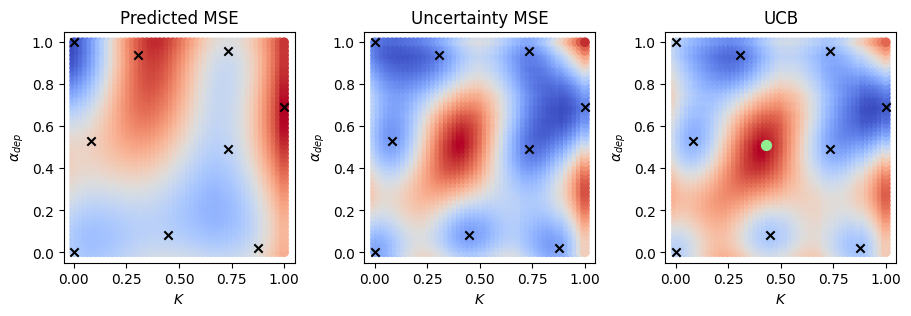


----------------- Iteration exp. 46 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 226.22it/s, init loss: 13224.9717, avg. loss [951-1000]: 12408.9158]



Inferred GP kernel parameters
k_length         [0.34849998 0.3694    ]
k_scale          0.4779
noise            0.0064
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.21it/s]



----------------- Iteration theory 46 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.56it/s, init loss: 13169.2988, avg. loss [951-1000]: 12475.2150]



Inferred GP kernel parameters
k_length         [0.3132     0.36789998]
k_scale          0.4222
noise            0.096499994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 121.94it/s]



----------------- Iteration exp. 47 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 218.11it/s, init loss: 13225.9766, avg. loss [951-1000]: 12407.7916]



Inferred GP kernel parameters
k_length         [0.3263     0.36879998]
k_scale          0.4867
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.82it/s]



----------------- Iteration theory 47 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.83it/s, init loss: 13169.3496, avg. loss [951-1000]: 12475.1721]



Inferred GP kernel parameters
k_length         [0.3229     0.36789998]
k_scale          0.42159998
noise            0.0986
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.61it/s]



----------------- Iteration exp. 48 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 219.95it/s, init loss: 13226.9287, avg. loss [951-1000]: 12407.9134]



Inferred GP kernel parameters
k_length         [0.3435 0.3721]
k_scale          0.46769997
noise            0.0064999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.10it/s]



----------------- Iteration theory 48 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.48it/s, init loss: 13169.2383, avg. loss [951-1000]: 12475.1753]



Inferred GP kernel parameters
k_length         [0.32279998 0.36789998]
k_scale          0.4163
noise            0.096099995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.40it/s]



----------------- Iteration exp. 49 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 219.06it/s, init loss: 13227.9346, avg. loss [951-1000]: 12406.2883]



Inferred GP kernel parameters
k_length         [0.3296     0.30159998]
k_scale          0.48279998
noise            0.0064
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.29it/s]



----------------- Iteration theory 49 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.44it/s, init loss: 13169.0068, avg. loss [951-1000]: 12475.5871]



Inferred GP kernel parameters
k_length         [0.3256     0.36789998]
k_scale          0.34489998
noise            0.15869999
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.00it/s]



----------------- Iteration exp. 50 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 227.38it/s, init loss: 13229.0039, avg. loss [951-1000]: 12402.1325]



Inferred GP kernel parameters
k_length         [0.3037     0.35909998]
k_scale          0.51019996
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.24it/s]



----------------- Iteration theory 50 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.25it/s, init loss: 13168.9395, avg. loss [951-1000]: 12475.1522]



Inferred GP kernel parameters
k_length         [0.3284     0.36789998]
k_scale          0.2995
noise            0.14549999
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.97it/s]



----------------- Theory model tune iter_50 -----------------

MSE 1.42
UCB beta =  50.0
1.6183224320411682


100%|██████████| 250/250 [00:01<00:00, 248.70it/s, init loss: 11.9219, avg. loss [229-240]: 2.6212]



Inferred GP parameters
k_length         [0.362      0.37899998]
k_scale          0.067499995
noise            0.0501
0.51835537 0.34780085


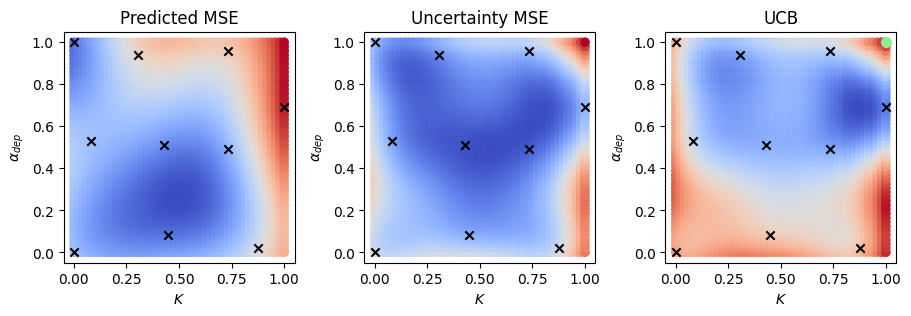


----------------- Iteration exp. 51 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 192.94it/s, init loss: 13229.9053, avg. loss [951-1000]: 12401.5542]



Inferred GP kernel parameters
k_length         [0.32999998 0.3302    ]
k_scale          0.48099998
noise            0.0063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 121.95it/s]



----------------- Iteration theory 51 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.71it/s, init loss: 13169.0430, avg. loss [951-1000]: 12475.1604]



Inferred GP kernel parameters
k_length         [0.3256     0.36789998]
k_scale          0.4131
noise            0.0946
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.73it/s]



----------------- Iteration exp. 52 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.96it/s, init loss: 13230.9131, avg. loss [951-1000]: 12405.6010]



Inferred GP kernel parameters
k_length         [0.3189     0.37109998]
k_scale          0.4876
noise            0.0077
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.39it/s]



----------------- Iteration theory 52 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.45it/s, init loss: 13169.0742, avg. loss [951-1000]: 12475.1651]



Inferred GP kernel parameters
k_length         [0.3215     0.36789998]
k_scale          0.4123
noise            0.0932
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.08it/s]



----------------- Iteration exp. 53 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 220.51it/s, init loss: 13232.0332, avg. loss [951-1000]: 12398.3288]



Inferred GP kernel parameters
k_length         [0.3044     0.19119999]
k_scale          0.4994
noise            0.0061
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.54it/s]



----------------- Iteration theory 53 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.66it/s, init loss: 13169.4102, avg. loss [951-1000]: 12475.1570]



Inferred GP kernel parameters
k_length         [0.32479998 0.36789998]
k_scale          0.41799998
noise            0.0971
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.20it/s]



----------------- Iteration exp. 54 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 230.63it/s, init loss: 13233.1816, avg. loss [951-1000]: 12398.4414]



Inferred GP kernel parameters
k_length         [0.3434 0.3908]
k_scale          0.4657
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.65it/s]



----------------- Iteration theory 54 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 532.25it/s, init loss: 13169.3184, avg. loss [951-1000]: 12475.0173]



Inferred GP kernel parameters
k_length         [0.3241     0.36789998]
k_scale          0.3734
noise            0.102699995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.69it/s]



----------------- Iteration exp. 55 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 165.88it/s, init loss: 13234.3096, avg. loss [951-1000]: 12403.7476]



Inferred GP kernel parameters
k_length         [0.3692 0.4515]
k_scale          0.445
noise            0.0064999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.85it/s]



----------------- Iteration theory 55 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.79it/s, init loss: 13169.3535, avg. loss [951-1000]: 12475.4017]



Inferred GP kernel parameters
k_length         [0.3308     0.36789998]
k_scale          0.3094
noise            0.1752
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.85it/s]



----------------- Theory model tune iter_55 -----------------

MSE 1.37
UCB beta =  22.271
1.6183224320411682


100%|██████████| 250/250 [00:00<00:00, 258.45it/s, init loss: 12.9485, avg. loss [229-240]: 2.4701]



Inferred GP parameters
k_length         [0.40089998 0.40019998]
k_scale          0.065799996
noise            0.043399997
-0.24581909 -0.35160553


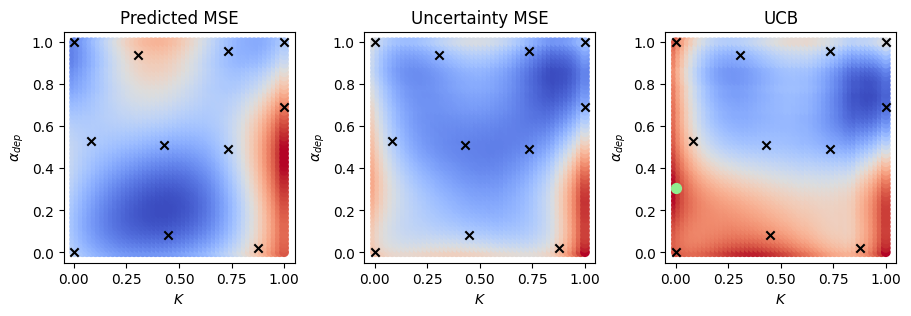


----------------- Iteration exp. 56 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.43it/s, init loss: 13235.2793, avg. loss [951-1000]: 12393.6533]



Inferred GP kernel parameters
k_length         [0.30719998 0.3152    ]
k_scale          0.486
noise            0.0061
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.76it/s]



----------------- Iteration theory 56 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 541.24it/s, init loss: 13169.2168, avg. loss [951-1000]: 12474.9586]



Inferred GP kernel parameters
k_length         [0.3254     0.36789998]
k_scale          0.3698
noise            0.1083
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.51it/s]



----------------- Iteration exp. 57 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.33it/s, init loss: 13236.2041, avg. loss [951-1000]: 12392.4994]



Inferred GP kernel parameters
k_length         [0.3884 0.3667]
k_scale          0.4693
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.45it/s]



----------------- Iteration theory 57 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 519.48it/s, init loss: 13169.0273, avg. loss [951-1000]: 12475.3864]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2626
noise            0.22829999
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.38it/s]



----------------- Iteration exp. 58 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.40it/s, init loss: 13237.3115, avg. loss [951-1000]: 12392.7446]



Inferred GP kernel parameters
k_length         [0.36589998 0.3479    ]
k_scale          0.4642
noise            0.0063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.91it/s]



----------------- Iteration theory 58 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 538.36it/s, init loss: 13168.9043, avg. loss [951-1000]: 12474.9039]



Inferred GP kernel parameters
k_length         [0.3137     0.36789998]
k_scale          0.3718
noise            0.096499994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.27it/s]



----------------- Iteration exp. 59 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.97it/s, init loss: 13238.2607, avg. loss [951-1000]: 12406.7963]



Inferred GP kernel parameters
k_length         [0.42659998 0.40399998]
k_scale          0.46969998
noise            0.0063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.38it/s]



----------------- Iteration theory 59 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 528.35it/s, init loss: 13169.4131, avg. loss [951-1000]: 12475.1082]



Inferred GP kernel parameters
k_length         [0.3096     0.36789998]
k_scale          0.39519998
noise            0.0903
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.09it/s]



----------------- Iteration exp. 60 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 172.00it/s, init loss: 13239.1367, avg. loss [951-1000]: 12391.3775]



Inferred GP kernel parameters
k_length         [0.3872     0.37039998]
k_scale          0.4522
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.98it/s]



----------------- Iteration theory 60 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.85it/s, init loss: 13169.6484, avg. loss [951-1000]: 12475.0293]



Inferred GP kernel parameters
k_length         [0.3188     0.36789998]
k_scale          0.39429998
noise            0.0883
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.72it/s]



----------------- Theory model tune iter_60 -----------------

MSE 1.73
UCB beta =  7.587
1.7261101305484772


100%|██████████| 250/250 [00:00<00:00, 257.11it/s, init loss: 14.0278, avg. loss [229-240]: 3.3510]



Inferred GP parameters
k_length         [0.49229997 0.4578    ]
k_scale          0.090399995
noise            0.047199998
-0.73885477 -0.8687802


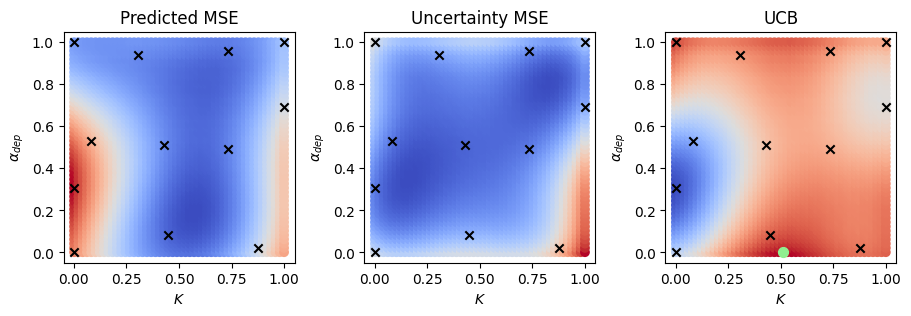


----------------- Iteration exp. 61 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.97it/s, init loss: 13240.0449, avg. loss [951-1000]: 12396.3140]



Inferred GP kernel parameters
k_length         [0.3364 0.1951]
k_scale          0.40109998
noise            0.0064
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.06it/s]



----------------- Iteration theory 61 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.26it/s, init loss: 13169.8662, avg. loss [951-1000]: 12475.0446]



Inferred GP kernel parameters
k_length         [0.3275     0.36789998]
k_scale          0.4105
noise            0.0937
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 121.95it/s]



----------------- Iteration exp. 62 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 171.64it/s, init loss: 13241.0879, avg. loss [951-1000]: 12388.0782]



Inferred GP kernel parameters
k_length         [0.3408 0.3671]
k_scale          0.48259997
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.61it/s]



----------------- Iteration theory 62 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.85it/s, init loss: 13169.4160, avg. loss [951-1000]: 12475.0653]



Inferred GP kernel parameters
k_length         [0.3279     0.36789998]
k_scale          0.3893
noise            0.099199995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.83it/s]



----------------- Iteration exp. 63 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.61it/s, init loss: 13242.0576, avg. loss [951-1000]: 12383.0655]



Inferred GP kernel parameters
k_length         [0.37539998 0.33229998]
k_scale          0.45679998
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.61it/s]



----------------- Iteration theory 63 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 519.08it/s, init loss: 13169.7891, avg. loss [951-1000]: 12474.9970]



Inferred GP kernel parameters
k_length         [0.3301     0.36789998]
k_scale          0.40109998
noise            0.0962
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.79it/s]



----------------- Iteration exp. 64 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.92it/s, init loss: 13243.0342, avg. loss [951-1000]: 12382.7581]



Inferred GP kernel parameters
k_length         [0.3375 0.3126]
k_scale          0.4694
noise            0.0061
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.95it/s]



----------------- Iteration theory 64 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 535.41it/s, init loss: 13169.4297, avg. loss [951-1000]: 12475.0743]



Inferred GP kernel parameters
k_length         [0.329      0.36789998]
k_scale          0.3944
noise            0.0973
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.17it/s]



----------------- Iteration exp. 65 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.54it/s, init loss: 13244.0928, avg. loss [951-1000]: 12381.2707]



Inferred GP kernel parameters
k_length         [0.3396 0.3215]
k_scale          0.4922
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.45it/s]



----------------- Iteration theory 65 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.12it/s, init loss: 13169.0938, avg. loss [951-1000]: 12475.1711]



Inferred GP kernel parameters
k_length         [0.3293     0.36789998]
k_scale          0.4134
noise            0.0963
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.75it/s]



----------------- Theory model tune iter_65 -----------------

MSE 1.44
UCB beta =  2.299
1.7261101305484772


100%|██████████| 250/250 [00:00<00:00, 254.46it/s, init loss: 15.0062, avg. loss [229-240]: 2.8979]



Inferred GP parameters
k_length         [0.5315     0.47399998]
k_scale          0.088199995
noise            0.039699998
-1.1019708 -1.2083994


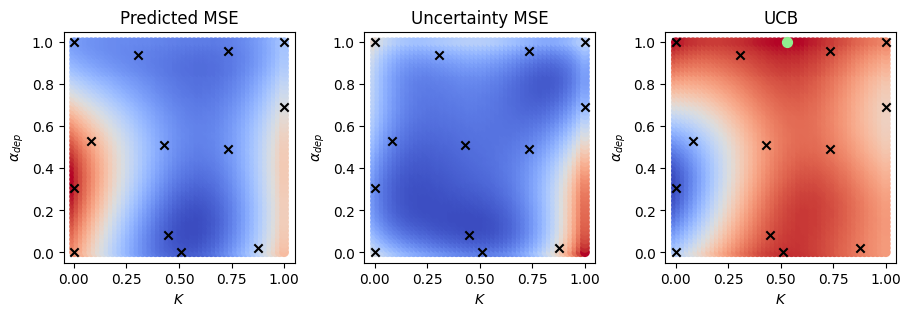


----------------- Iteration exp. 66 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 173.36it/s, init loss: 13244.9570, avg. loss [951-1000]: 12382.6598]



Inferred GP kernel parameters
k_length         [0.3022 0.3168]
k_scale          0.4939
noise            0.0061
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.78it/s]



----------------- Iteration theory 66 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 513.69it/s, init loss: 13169.0762, avg. loss [951-1000]: 12475.1778]



Inferred GP kernel parameters
k_length         [0.3215     0.36789998]
k_scale          0.41259998
noise            0.094
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.69it/s]



----------------- Iteration exp. 67 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.64it/s, init loss: 13246.0127, avg. loss [951-1000]: 12375.0959]



Inferred GP kernel parameters
k_length         [0.3662 0.3032]
k_scale          0.4563
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.16it/s]



----------------- Iteration theory 67 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.62it/s, init loss: 13169.2559, avg. loss [951-1000]: 12475.1952]



Inferred GP kernel parameters
k_length         [0.3157     0.36789998]
k_scale          0.4143
noise            0.0932
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.35it/s]



----------------- Iteration exp. 68 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.09it/s, init loss: 13246.9189, avg. loss [951-1000]: 12377.2774]



Inferred GP kernel parameters
k_length         [0.32369998 0.34759998]
k_scale          0.49319997
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.38it/s]



----------------- Iteration theory 68 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 515.08it/s, init loss: 13169.3525, avg. loss [951-1000]: 12474.9357]



Inferred GP kernel parameters
k_length         [0.3153     0.36789998]
k_scale          0.3724
noise            0.102699995
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.60it/s]



----------------- Iteration exp. 69 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 166.15it/s, init loss: 13247.9590, avg. loss [951-1000]: 12373.8989]



Inferred GP kernel parameters
k_length         [0.265  0.2023]
k_scale          0.4624
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.53it/s]



----------------- Iteration theory 69 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.99it/s, init loss: 13169.1670, avg. loss [951-1000]: 12475.2702]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2819
noise            0.21139999
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.00it/s]



----------------- Iteration exp. 70 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 174.28it/s, init loss: 13248.9180, avg. loss [951-1000]: 12372.9555]



Inferred GP kernel parameters
k_length         [0.3187 0.3227]
k_scale          0.4899
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.81it/s]



----------------- Iteration theory 70 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 534.64it/s, init loss: 13169.4443, avg. loss [951-1000]: 12474.9370]



Inferred GP kernel parameters
k_length         [0.3251     0.36789998]
k_scale          0.37129998
noise            0.1087
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.33it/s]



----------------- Theory model tune iter_70 -----------------

MSE 1.33
UCB beta =  0.67
1.7261101305484772


100%|██████████| 250/250 [00:00<00:00, 254.47it/s, init loss: 15.9853, avg. loss [229-240]: 2.4953]



Inferred GP parameters
k_length         [0.59459996 0.4806    ]
k_scale          0.0892
noise            0.0347
-1.2442349 -1.3828875


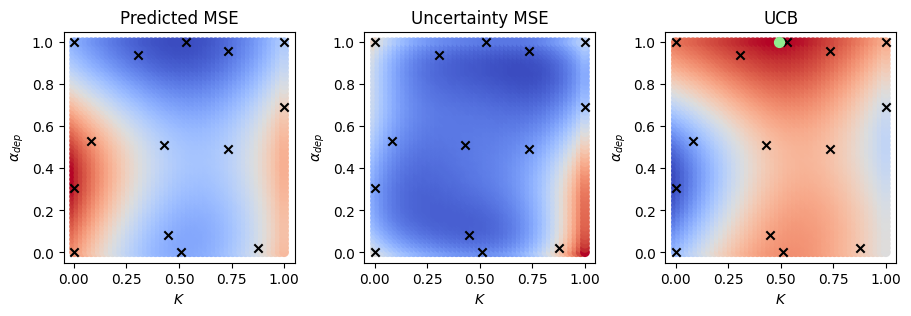


----------------- Iteration exp. 71 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 159.32it/s, init loss: 13249.8672, avg. loss [951-1000]: 12397.7255]



Inferred GP kernel parameters
k_length         [0.35459998 0.112     ]
k_scale          0.4165
noise            0.007999999
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.37it/s]



----------------- Iteration theory 71 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 513.19it/s, init loss: 13169.5312, avg. loss [951-1000]: 12475.0603]



Inferred GP kernel parameters
k_length         [0.3224     0.36789998]
k_scale          0.3872
noise            0.1008
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.83it/s]



----------------- Iteration exp. 72 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.07it/s, init loss: 13250.9785, avg. loss [951-1000]: 12368.3393]



Inferred GP kernel parameters
k_length         [0.29459998 0.3462    ]
k_scale          0.49589998
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.96it/s]



----------------- Iteration theory 72 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.46it/s, init loss: 13169.4531, avg. loss [951-1000]: 12475.0729]



Inferred GP kernel parameters
k_length         [0.3272     0.36789998]
k_scale          0.384
noise            0.1019
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.20it/s]



----------------- Iteration exp. 73 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.20it/s, init loss: 13252.1650, avg. loss [951-1000]: 12368.3696]



Inferred GP kernel parameters
k_length         [0.3892     0.22809999]
k_scale          0.4493
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.76it/s]



----------------- Iteration theory 73 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.01it/s, init loss: 13169.2842, avg. loss [951-1000]: 12475.0670]



Inferred GP kernel parameters
k_length         [0.3229     0.36789998]
k_scale          0.39609998
noise            0.0923
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 121.94it/s]



----------------- Iteration exp. 74 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 175.96it/s, init loss: 13253.1875, avg. loss [951-1000]: 12363.5578]



Inferred GP kernel parameters
k_length         [0.32209998 0.3547    ]
k_scale          0.4964
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.23it/s]



----------------- Iteration theory 74 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.76it/s, init loss: 13169.4004, avg. loss [951-1000]: 12475.0136]



Inferred GP kernel parameters
k_length         [0.3234     0.36789998]
k_scale          0.37579998
noise            0.0972
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.55it/s]



----------------- Iteration exp. 75 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 158.90it/s, init loss: 13254.1982, avg. loss [951-1000]: 12365.6725]



Inferred GP kernel parameters
k_length         [0.3041 0.1915]
k_scale          0.47869998
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.86it/s]



----------------- Iteration theory 75 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.96it/s, init loss: 13169.4990, avg. loss [951-1000]: 12475.0112]



Inferred GP kernel parameters
k_length         [0.3234     0.36789998]
k_scale          0.3848
noise            0.0986
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.77it/s]



----------------- Theory model tune iter_75 -----------------

MSE 1.43
UCB beta =  0.194
1.7261101305484772


100%|██████████| 250/250 [00:01<00:00, 246.56it/s, init loss: 16.9248, avg. loss [229-240]: 1.8302]



Inferred GP parameters
k_length         [0.6216 0.4851]
k_scale          0.0875
noise            0.0301
-1.334173 -1.4707268


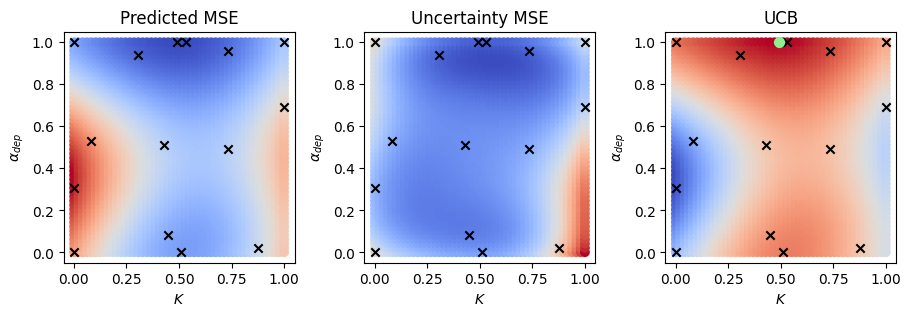


----------------- Iteration exp. 76 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.35it/s, init loss: 13255.2158, avg. loss [951-1000]: 12360.0229]



Inferred GP kernel parameters
k_length         [0.2642     0.30269998]
k_scale          0.4992
noise            0.0056999996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.00it/s]



----------------- Iteration theory 76 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.04it/s, init loss: 13169.5020, avg. loss [951-1000]: 12475.0787]



Inferred GP kernel parameters
k_length         [0.32189998 0.36789998]
k_scale          0.4006
noise            0.0949
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.85it/s]



----------------- Iteration exp. 77 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 163.14it/s, init loss: 13256.1816, avg. loss [951-1000]: 12358.6244]



Inferred GP kernel parameters
k_length         [0.2787 0.3439]
k_scale          0.4994
noise            0.0056999996
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.79it/s]



----------------- Iteration theory 77 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.55it/s, init loss: 13169.4453, avg. loss [951-1000]: 12475.1134]



Inferred GP kernel parameters
k_length         [0.3186     0.36789998]
k_scale          0.4016
noise            0.097799994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.99it/s]



----------------- Iteration exp. 78 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 175.73it/s, init loss: 13257.1094, avg. loss [951-1000]: 12369.4306]



Inferred GP kernel parameters
k_length         [0.3035 0.1796]
k_scale          0.421
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.60it/s]



----------------- Iteration theory 78 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.63it/s, init loss: 13169.3516, avg. loss [951-1000]: 12474.9114]



Inferred GP kernel parameters
k_length         [0.32799998 0.36789998]
k_scale          0.3719
noise            0.1074
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.55it/s]



----------------- Iteration exp. 79 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.85it/s, init loss: 13258.0586, avg. loss [951-1000]: 12364.7339]



Inferred GP kernel parameters
k_length         [0.32529998 0.18869999]
k_scale          0.39929998
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.25it/s]



----------------- Iteration theory 79 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.07it/s, init loss: 13169.2588, avg. loss [951-1000]: 12475.1546]



Inferred GP kernel parameters
k_length         [0.3276     0.36789998]
k_scale          0.4201
noise            0.0994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.33it/s]



----------------- Iteration exp. 80 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 170.57it/s, init loss: 13259.1357, avg. loss [951-1000]: 12377.5298]



Inferred GP kernel parameters
k_length         [0.3281     0.17019999]
k_scale          0.3267
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 119.59it/s]



----------------- Iteration theory 80 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 518.69it/s, init loss: 13169.1475, avg. loss [951-1000]: 12475.2260]



Inferred GP kernel parameters
k_length         [0.3277     0.36789998]
k_scale          0.4125
noise            0.1006
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.12it/s]



----------------- Theory model tune iter_80 -----------------

MSE 1.22
UCB beta =  0.056
1.7261101305484772


100%|██████████| 250/250 [00:00<00:00, 257.35it/s, init loss: 17.8737, avg. loss [229-240]: 1.6170]



Inferred GP parameters
k_length         [0.6469 0.4897]
k_scale          0.090799995
noise            0.0295
-1.3387865 -1.5145589


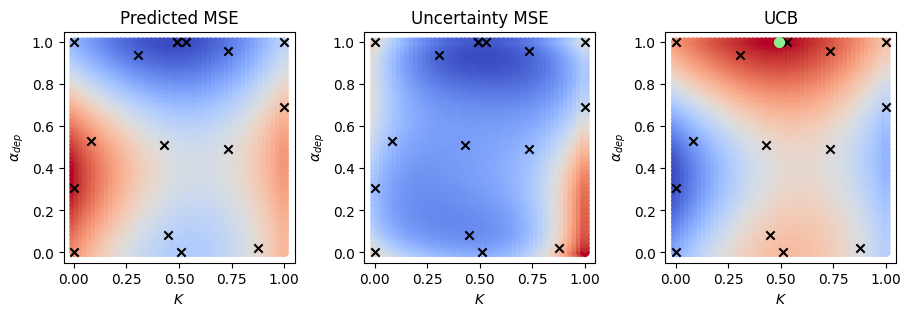


----------------- Iteration exp. 81 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 165.64it/s, init loss: 13260.1465, avg. loss [951-1000]: 12356.0292]



Inferred GP kernel parameters
k_length         [0.3622 0.3452]
k_scale          0.4736
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.68it/s]



----------------- Iteration theory 81 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.32it/s, init loss: 13169.1475, avg. loss [951-1000]: 12475.2262]



Inferred GP kernel parameters
k_length         [0.3277     0.36789998]
k_scale          0.4125
noise            0.1006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.27it/s]



----------------- Iteration exp. 82 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 172.90it/s, init loss: 13261.1699, avg. loss [951-1000]: 12358.4831]



Inferred GP kernel parameters
k_length         [0.38779998 0.1854    ]
k_scale          0.3872
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.91it/s]



----------------- Iteration theory 82 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.93it/s, init loss: 13168.8164, avg. loss [951-1000]: 12475.0740]



Inferred GP kernel parameters
k_length         [0.3216     0.36789998]
k_scale          0.4091
noise            0.087799996
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.29it/s]



----------------- Iteration exp. 83 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.73it/s, init loss: 13262.0439, avg. loss [951-1000]: 12352.3067]



Inferred GP kernel parameters
k_length         [0.4551 0.4495]
k_scale          0.4605
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.90it/s]



----------------- Iteration theory 83 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.29it/s, init loss: 13169.0723, avg. loss [951-1000]: 12475.1531]



Inferred GP kernel parameters
k_length         [0.32279998 0.36789998]
k_scale          0.4116
noise            0.0927
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.03it/s]



----------------- Iteration exp. 84 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.20it/s, init loss: 13263.0234, avg. loss [951-1000]: 12373.4910]



Inferred GP kernel parameters
k_length         [0.3032 0.1391]
k_scale          0.43559998
noise            0.0072999997
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.74it/s]



----------------- Iteration theory 84 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.32it/s, init loss: 13169.2158, avg. loss [951-1000]: 12474.9608]



Inferred GP kernel parameters
k_length         [0.329      0.36789998]
k_scale          0.36839998
noise            0.1078
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.82it/s]



----------------- Iteration exp. 85 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 160.63it/s, init loss: 13264.1904, avg. loss [951-1000]: 12349.3149]



Inferred GP kernel parameters
k_length         [0.3286     0.35439998]
k_scale          0.49679998
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.13it/s]



----------------- Iteration theory 85 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.28it/s, init loss: 13169.3037, avg. loss [951-1000]: 12475.1629]



Inferred GP kernel parameters
k_length         [0.327      0.36789998]
k_scale          0.4184
noise            0.098
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.20it/s]



----------------- Theory model tune iter_85 -----------------

MSE 1.44
UCB beta =  0.017
1.7261101305484772


100%|██████████| 250/250 [00:01<00:00, 239.70it/s, init loss: 18.7821, avg. loss [229-240]: 0.8820]



Inferred GP parameters
k_length         [0.65169996 0.4865    ]
k_scale          0.0892
noise            0.0266
-1.3679311 -1.5383401


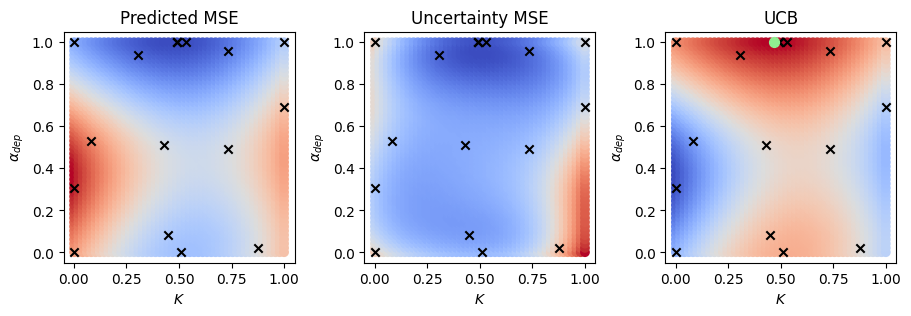


----------------- Iteration exp. 86 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 180.12it/s, init loss: 13265.1045, avg. loss [951-1000]: 12356.1954]



Inferred GP kernel parameters
k_length         [0.3715 0.1619]
k_scale          0.3874
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.79it/s]



----------------- Iteration theory 86 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.03it/s, init loss: 13169.2158, avg. loss [951-1000]: 12474.9608]



Inferred GP kernel parameters
k_length         [0.329      0.36789998]
k_scale          0.36839998
noise            0.1078
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.29it/s]



----------------- Iteration exp. 87 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 156.00it/s, init loss: 13266.3252, avg. loss [951-1000]: 12350.2864]



Inferred GP kernel parameters
k_length         [0.3276 0.2179]
k_scale          0.4506
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.63it/s]



----------------- Iteration theory 87 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.80it/s, init loss: 13169.2959, avg. loss [951-1000]: 12475.1473]



Inferred GP kernel parameters
k_length         [0.327      0.36789998]
k_scale          0.4157
noise            0.097899996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.45it/s]



----------------- Iteration exp. 88 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.86it/s, init loss: 13267.3105, avg. loss [951-1000]: 12341.5150]



Inferred GP kernel parameters
k_length         [0.2933 0.295 ]
k_scale          0.48499998
noise            0.0056
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.44it/s]



----------------- Iteration theory 88 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.15it/s, init loss: 13169.1074, avg. loss [951-1000]: 12475.2026]



Inferred GP kernel parameters
k_length         [0.3277     0.36789998]
k_scale          0.41099998
noise            0.0998
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.71it/s]



----------------- Iteration exp. 89 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 154.02it/s, init loss: 13268.2500, avg. loss [951-1000]: 12364.5637]



Inferred GP kernel parameters
k_length         [0.36429998 0.1959    ]
k_scale          0.41329998
noise            0.0077
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.81it/s]



----------------- Iteration theory 89 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 519.91it/s, init loss: 13169.0645, avg. loss [951-1000]: 12475.1474]



Inferred GP kernel parameters
k_length         [0.3204     0.36789998]
k_scale          0.40879998
noise            0.0925
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.64it/s]



----------------- Iteration exp. 90 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 169.57it/s, init loss: 13269.2637, avg. loss [951-1000]: 12347.6642]



Inferred GP kernel parameters
k_length         [0.1725 0.3029]
k_scale          0.4484
noise            0.0058999998
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.28it/s]



----------------- Iteration theory 90 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 504.27it/s, init loss: 13169.2285, avg. loss [951-1000]: 12474.9707]



Inferred GP kernel parameters
k_length         [0.32729998 0.36789998]
k_scale          0.3689
noise            0.107599996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.39it/s]



----------------- Theory model tune iter_90 -----------------

MSE 1.26
UCB beta =  0.006
1.7261101305484772


100%|██████████| 250/250 [00:01<00:00, 232.76it/s, init loss: 19.6950, avg. loss [229-240]: 0.3089]



Inferred GP parameters
k_length         [0.673  0.4811]
k_scale          0.090799995
noise            0.024999999
-1.3581892 -1.5519865


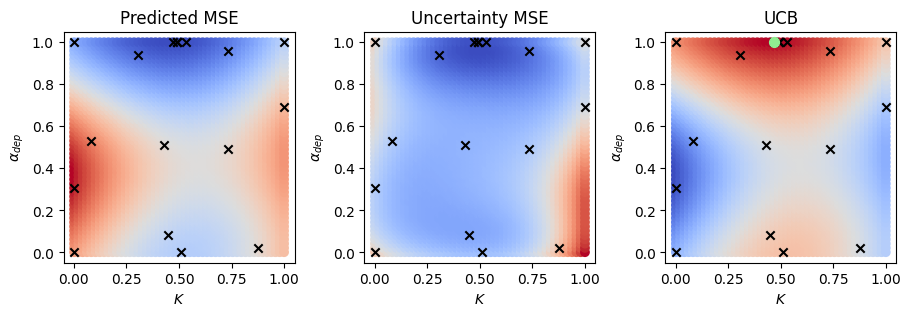


----------------- Iteration exp. 91 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.59it/s, init loss: 13270.2119, avg. loss [951-1000]: 12338.4160]



Inferred GP kernel parameters
k_length         [0.3462 0.3408]
k_scale          0.47469997
noise            0.0056999996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.66it/s]



----------------- Iteration theory 91 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.92it/s, init loss: 13169.3203, avg. loss [951-1000]: 12475.1763]



Inferred GP kernel parameters
k_length         [0.32549998 0.36789998]
k_scale          0.41849998
noise            0.097899996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.13it/s]



----------------- Iteration exp. 92 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.53it/s, init loss: 13271.0771, avg. loss [951-1000]: 12349.8421]



Inferred GP kernel parameters
k_length         [0.1417     0.31669998]
k_scale          0.4005
noise            0.0063
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.25it/s]



----------------- Iteration theory 92 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.52it/s, init loss: 13169.2285, avg. loss [951-1000]: 12474.9691]



Inferred GP kernel parameters
k_length         [0.3269     0.36789998]
k_scale          0.3691
noise            0.107499994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.98it/s]



----------------- Iteration exp. 93 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 152.89it/s, init loss: 13272.0293, avg. loss [951-1000]: 12342.7041]



Inferred GP kernel parameters
k_length         [0.3351 0.1661]
k_scale          0.4001
noise            0.006
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.71it/s]



----------------- Iteration theory 93 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.28it/s, init loss: 13169.3203, avg. loss [951-1000]: 12475.1762]



Inferred GP kernel parameters
k_length         [0.3254     0.36789998]
k_scale          0.41849998
noise            0.097799994
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 124.82it/s]



----------------- Iteration exp. 94 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 166.73it/s, init loss: 13273.1191, avg. loss [951-1000]: 12336.0054]



Inferred GP kernel parameters
k_length         [0.1733 0.273 ]
k_scale          0.45139998
noise            0.0056
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.88it/s]



----------------- Iteration theory 94 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.95it/s, init loss: 13169.1328, avg. loss [951-1000]: 12475.2207]



Inferred GP kernel parameters
k_length         [0.3276     0.36789998]
k_scale          0.41369998
noise            0.0997
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 120.29it/s]



----------------- Iteration exp. 95 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 155.55it/s, init loss: 13273.9980, avg. loss [951-1000]: 12340.0521]



Inferred GP kernel parameters
k_length         [0.3035 0.1671]
k_scale          0.4484
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.81it/s]



----------------- Iteration theory 95 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.90it/s, init loss: 13168.8604, avg. loss [951-1000]: 12475.1081]



Inferred GP kernel parameters
k_length         [0.3215     0.36789998]
k_scale          0.4242
noise            0.0849
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.06it/s]



----------------- Theory model tune iter_95 -----------------

MSE 1.38
UCB beta =  0.002
1.7261101305484772


100%|██████████| 250/250 [00:01<00:00, 224.01it/s, init loss: 20.5872, avg. loss [229-240]: -0.5767]



Inferred GP parameters
k_length         [0.6849 0.4928]
k_scale          0.0903
noise            0.022599999
-1.366804 -1.5567335


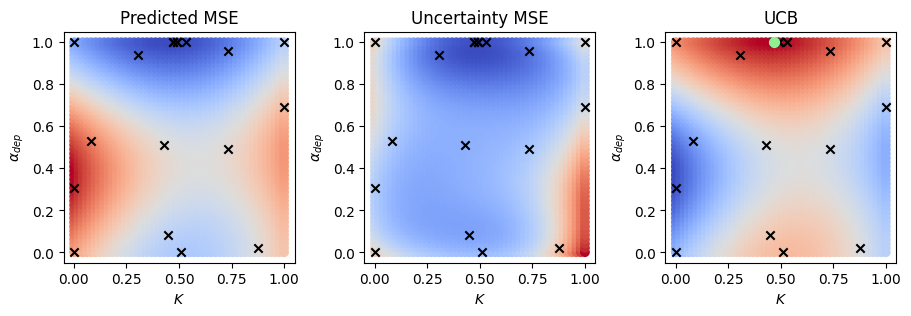


----------------- Iteration exp. 96 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 158.53it/s, init loss: 13275.0283, avg. loss [951-1000]: 12344.7587]



Inferred GP kernel parameters
k_length         [0.4005 0.1846]
k_scale          0.4069
noise            0.0061
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.70it/s]



----------------- Iteration theory 96 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 512.33it/s, init loss: 13169.0713, avg. loss [951-1000]: 12475.1478]



Inferred GP kernel parameters
k_length         [0.3233     0.36789998]
k_scale          0.41149998
noise            0.0927
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.08it/s]



----------------- Iteration exp. 97 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 157.36it/s, init loss: 13276.0371, avg. loss [951-1000]: 12332.7600]



Inferred GP kernel parameters
k_length         [0.3108 0.3394]
k_scale          0.47559997
noise            0.0058
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.85it/s]



----------------- Iteration theory 97 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.40it/s, init loss: 13169.2637, avg. loss [951-1000]: 12475.1624]



Inferred GP kernel parameters
k_length         [0.3268     0.36789998]
k_scale          0.41799998
noise            0.097899996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 122.74it/s]



----------------- Iteration exp. 98 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 171.57it/s, init loss: 13276.9961, avg. loss [951-1000]: 12327.1380]



Inferred GP kernel parameters
k_length         [0.3287 0.3692]
k_scale          0.4842
noise            0.0056999996
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.64it/s]



----------------- Iteration theory 98 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.02it/s, init loss: 13169.1816, avg. loss [951-1000]: 12474.9523]



Inferred GP kernel parameters
k_length         [0.3292     0.36789998]
k_scale          0.36789998
noise            0.1081
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 119.30it/s]



----------------- Iteration exp. 99 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 160.92it/s, init loss: 13277.8516, avg. loss [951-1000]: 12327.2578]



Inferred GP kernel parameters
k_length         [0.38869998 0.34059998]
k_scale          0.47259998
noise            0.0056999996
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.45it/s]



----------------- Iteration theory 99 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.53it/s, init loss: 13169.2637, avg. loss [951-1000]: 12475.1620]



Inferred GP kernel parameters
k_length         [0.3267     0.36789998]
k_scale          0.4181
noise            0.097899996
---Performing simulation---


100%|██████████| 4998/4998 [00:40<00:00, 123.47it/s]



----------------- Iteration exp. 100 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.00it/s, init loss: 13278.9395, avg. loss [951-1000]: 12343.1258]



Inferred GP kernel parameters
k_length         [0.42409998 0.1504    ]
k_scale          0.4006
noise            0.0061999997
---Performing simulation---


100%|██████████| 4998/4998 [00:41<00:00, 121.26it/s]



----------------- Iteration theory 100 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 338.43it/s, init loss: 13169.1816, avg. loss [951-1000]: 12474.9522]



Inferred GP kernel parameters
k_length         [0.3292     0.36789998]
k_scale          0.36789998
noise            0.1081
---Performing simulation---


100%|██████████| 4998/4998 [00:42<00:00, 118.50it/s]



----------------- Theory model tune iter_100 -----------------

MSE 1.38
UCB beta =  0.001
1.7261101305484772


100%|██████████| 250/250 [00:01<00:00, 231.16it/s, init loss: 21.4733, avg. loss [229-240]: -1.5153]



Inferred GP parameters
k_length         [0.70089996 0.5045    ]
k_scale          0.0897
noise            0.020499999
-1.3664373 -1.5579164


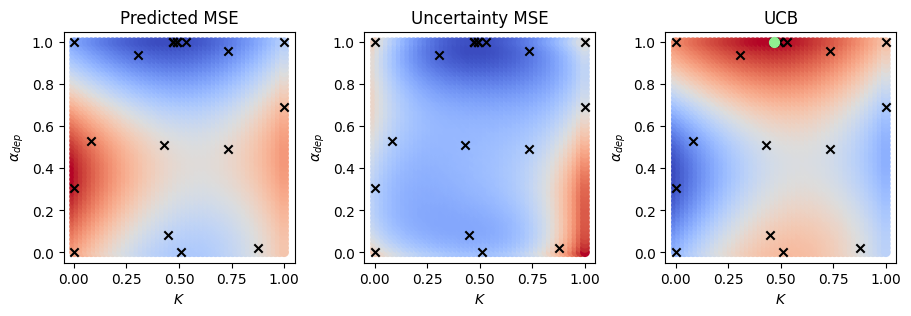

In [17]:
n_steps = 601

#experiment/theory ratio
exp_th = 1

#number of seed points theory
N = 5 #min 2

#number of seed points exp
N_exp = 10

#theory update rate
upd_rate = 20

#outer gp params
ls = dist.Gamma(2, 5)
mean_function = None

#beta for UCB of outer loop
beta0 = 100
beta_last = 0.001

# Calculate the decay rate
beta_sequence = sigmoid_decay(beta0, beta_last, n_steps, a=2.5, b=0)

#'tail' to train DKL-T model
mem_tail = 20

lambda_y = lambda x, coupl, a_dep: ferrosim_calc(x,
                                                gamma = 100,
                                                defect_field = (30,0),
                                                c_const = coupl,
                                                Eamp = (1E-9, 2),
                                                time_vec_length = 5000,
                                                dep_alpha = a_dep)

list_model_seed = np.random.randint(0,len(coord_adj), 10)

seeds_model = [list_model_seed[0],]
c, a = coord_adj[seeds_model[-1]]

mse = []

res_dict = {'X_th': X,
            'coord_th': coords_th,
            'X_exp': X_exp,
            'coords_exp': coords,
            'coord_adj': coord_adj}




print('\n----------------- Seed points theory -----------------\n')
seeds, X_train_dkl, y_train_dkl, y_train, loops_arrays = seeds_theory(np.array(X), n=N, adj_p = (c,a))
#vis_seeds(seeds, X, loops_arrays, par=(c,a))

res_dict['y_seed_th'] = y_train
res_dict['seed_th'] = seeds

print('\n----------------- Seed points exp. -----------------\n')
seed_exp, X_train_dkl_exp, y_train_dkl, y_train_exp, loops_arrays = seeds_theory(X_exp, n=N_exp, adj_p = (0.3,0.5))
#vis_seeds(seed_exp, X_exp, loops_arrays, par=(0.5,0.3))

res_dict['y_seed_exp'] = y_train_exp
res_dict['seed_exp'] = seed_exp


for i in range(n_steps):
  res_dict['iter_{}'.format(i)] = {}

  print(f'\n----------------- Iteration exp. {i} -----------------\n')
  seed_exp, X_train_dkl_exp, y_train_exp, dkl_res_exp, dkl_model_exp = iteration_theory(seed_exp,
                                                                                        np.array(X_exp),
                                                                                         X_train_dkl_exp,
                                                                                        y_train_exp,
                                                                                        coords=coords_exp,
                                                                                        adj_p = (0.3,0.5),
                                                                                        mem_tail = 1000)

  res_dict['iter_{}'.format(i)]['seed_exp'] = seed_exp
  res_dict['iter_{}'.format(i)]['y_exp'] = y_train_exp
  res_dict['iter_{}'.format(i)]['dkl_res_exp'] = dkl_res_exp
  res_dict['iter_{}'.format(i)]['params_exp'] = dkl_model_exp.get_samples()[1]


  if i % exp_th == 0:
    print(f'\n----------------- Iteration theory {i} -----------------\n')
    seeds, X_train_dkl, y_train, dkl_res, dkl_model_th = iteration_theory(seeds,
                                                                          np.array(X),
                                                                          X_train_dkl,
                                                                          y_train,
                                                                          coords=coords_th,
                                                                          adj_p = (c,a),
                                                                          mem_tail = mem_tail)
    res_dict['iter_{}'.format(i)]['seed_th'] = seeds
    res_dict['iter_{}'.format(i)]['y_th'] = y_train
    res_dict['iter_{}'.format(i)]['dkl_res_th'] = dkl_res
    res_dict['iter_{}'.format(i)]['params_th'] = dkl_model_th.get_samples()[1]

    if (i > 0) and (i % (exp_th*upd_rate)==0):
      print(f'\n----------------- Theory model tune iter_{i} -----------------\n')
      key1, key2 = gpax.utils.get_keys()
      patterns_exp = b_features_all[seed_exp]#]
      sh = patterns_exp.shape
      y_th, _ = dkl_model_th.predict(key1, patterns_exp.reshape(sh[0], -1))

      _, n_y_tr = normalize(y_train_exp)#[-tail_mse:])
      _, n_y_th = normalize(y_th)

      mse.append(np.mean(np.square(n_y_tr - n_y_th))*10)
      print(f'MSE {round(mse[-1], 2)}')

      res_dict['iter_{}'.format(i)]['mse'] = mse

      if len(mse) < 3: #initially choose randomly
        seeds_model.append(list_model_seed[len(mse)])
        res_dict['iter_{}'.format(i)]['seeds_model'] = seeds_model

        c, a = coord_adj[seeds_model[-1]]
      else:
        print('UCB beta = ', round(beta_sequence[i],3))
        next_seeds_model, pred, params = model_adjust_iteration(seeds_model,
                                                                np.array(mse),
                                                                np.array(coord_adj),
                                                                mem_tail = 50,
                                                                beta = beta_sequence[i],
                                                                lengthscale_prior_dist=ls)


        seeds_model.append(next_seeds_model)
        c, a = coord_adj[seeds_model[-1]]

        res_dict['iter_{}'.format(i)]['pred_adj'] = pred
        res_dict['iter_{}'.format(i)]['params_adj'] = params
        res_dict['iter_{}'.format(i)]['seeds_model'] = seeds_model

In [ ]:
save_dict_to_hdf5('res.h5', res_dict)

# 6. Forensic

Pre-aquired data

In [41]:
!gdown https://drive.google.com/file/d/1nWG1oJXa2pYtN0YVVkHGkSR60vcZqJCk/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1nWG1oJXa2pYtN0YVVkHGkSR60vcZqJCk
To: /content/1_th_th_standard.h5
100% 43.2M/43.2M [00:00<00:00, 80.5MB/s]


In [40]:
!gdown https://drive.google.com/file/d/1bqUwasYHQ0Px9yoM8HboMaACDeuIJIh3/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1bqUwasYHQ0Px9yoM8HboMaACDeuIJIh3
To: /content/2_th_th_structural.h5
100% 43.3M/43.3M [00:00<00:00, 70.5MB/s]


In [25]:
#@title forensic functions
def trajectory_forensic(file_name):

  def get_numeric_suffix(item):
    return int(item.split('_')[-1])

  traj_data = load_hdf5_to_dict(file_name)
  iter_elements = [element for element in traj_data.keys() if element.startswith('iter_')]
  iter_elements = sorted(iter_elements, key=get_numeric_suffix)

  res_dict = {'X_exp':       traj_data['X_exp'],
              'coord_exp':  traj_data['coords_exp'],
              'seed_exp':    traj_data['seed_exp'],
              'y_seed_exp':  traj_data['y_seed_exp'],

              'X_th':        traj_data['X_th'],
              'coord_th':    traj_data['coord_th'],
              'seed_th':     traj_data['seed_th'],
              'y_seed_th':   traj_data['y_seed_th'],

              'coord_out': traj_data['coord_adj']}

  dkl_res_exp = []
  dkl_res_th  = []
  dkl_res_out = []

  ind_exp     = np.array([], dtype=int)
  ind_th      = np.array([], dtype=int)
  ind_mse     = np.array([], dtype=int)
  ind_dkl_out = np.array([], dtype=int)

  dkl_out_klength = []
  dkl_out_kscale  = []
  dkl_out_noise   = []

  exp_klength = []
  exp_kscale  = []
  exp_noise   = []
  th_klength = []
  th_kscale  = []
  th_noise   = []


  for el in iter_elements:
    i = int(el.split('_')[1])
    ind_exp = np.append(ind_exp, i)

    dkl_res_exp.append(traj_data[el]['dkl_res_exp'])
    exp_klength.append(traj_data[el]['params_exp']['k_length'])
    exp_kscale.append(traj_data[el]['params_exp']['k_scale'])
    exp_noise.append(traj_data[el]['params_exp']['noise'])

    if 'dkl_res_th' in traj_data[el]:
      ind_th = np.append(ind_th, i)
      dkl_res_th.append(traj_data[el]['dkl_res_th'])
      th_klength.append(traj_data[el]['params_th']['k_length'])
      th_kscale.append(traj_data[el]['params_th']['k_scale'])
      th_noise.append(traj_data[el]['params_th']['noise'])

    if 'mse' in traj_data[el]:
      ind_mse = np.append(ind_mse, i)

    if 'params_adj' in traj_data[el]:
      ind_dkl_out = np.append(ind_dkl_out, i)
      dkl_res_out.append(traj_data[el]['pred_adj'])
      dkl_out_klength.append(traj_data[el]['params_adj']['k_length'])
      dkl_out_kscale.append(traj_data[el]['params_adj']['k_scale'])
      dkl_out_noise.append(traj_data[el]['params_adj']['noise'])

  res_dict['ind_exp']              = ind_exp
  res_dict['dkl_res_exp']          = np.array(dkl_res_exp)
  res_dict['seed_last_step_exp']   = np.array(traj_data[iter_elements[-1]]['seed_exp'])
  res_dict['y_exp']                = np.array(traj_data[iter_elements[-1]]['y_exp'])

  res_dict['ind_th']               = ind_th
  res_dict['dkl_res_th']           = np.array(dkl_res_th)
  res_dict['seed_last_step_th']    = np.array(traj_data[f'iter_{ind_th[-1]}']['seed_th'])
  res_dict['y_th']                 = np.array(traj_data[f'iter_{ind_th[-1]}']['y_th'])

  res_dict['ind_mse']              = ind_mse
  res_dict['mse']                  = np.array(traj_data[f'iter_{ind_mse[-1]}']['mse'])

  res_dict['ind_dkl_out']          = ind_dkl_out
  res_dict['dkl_res_out']          = np.array(dkl_res_out)
  res_dict['seed_last_step_out']   = np.array(traj_data[f'iter_{ind_dkl_out[-1]}']['seeds_model'])

  res_dict['dkl_out_klength']      = np.array(dkl_out_klength)
  res_dict['dkl_out_noise']        = np.array(dkl_out_noise)
  res_dict['dkl_out_kscale']       = np.array(dkl_out_kscale)

  res_dict['exp_klength']      = np.array(exp_klength)
  res_dict['exp_noise']        = np.array(exp_noise)
  res_dict['exp_kscale']       = np.array(exp_kscale)

  res_dict['th_klength']      = np.array(th_klength)
  res_dict['th_noise']        = np.array(th_noise)
  res_dict['th_kscale']       = np.array(th_kscale)

  return res_dict


In [59]:
#@title beta

'''
Unfortunately, I did not save the beta sequence in the data files.
This the beta decay I used for the experimentation presented in the article.
'''

# Calculate the decay rate
beta_sequence = sigmoid_decay(100, 0.001, 600, a=2.5, b=0)

In [42]:
res = trajectory_forensic('1_th_th_standard.h5')

In [43]:
#extract some specific dependencies from the dict
dkl_exp = res['dkl_res_exp'].mean(-1)
dkl_th = res['dkl_res_th'].mean(-1)

Text(0, 0.5, 'Average uncertainty')

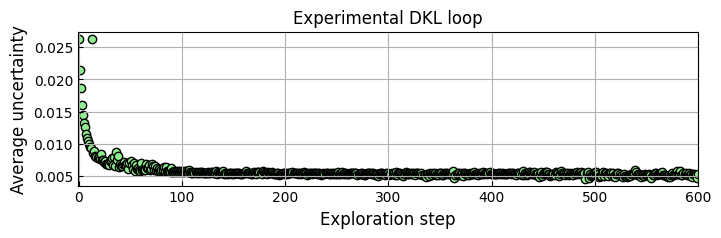

In [44]:
fig, ax = plt.subplots(figsize=(8,2))

ax.scatter(res['ind_exp'], dkl_exp[:,1], marker='o', c='lightgreen',
              edgecolor='black')
ax.set_title('Experimental DKL loop')
ax.set_xlim(-1,600)
ax.tick_params('both', direction='in')
ax.grid(True)
ax.set_xlabel('Exploration step', fontsize=12)
ax.set_ylabel('Average uncertainty', fontsize=12)

Text(0, 0.5, 'Average uncertainty')

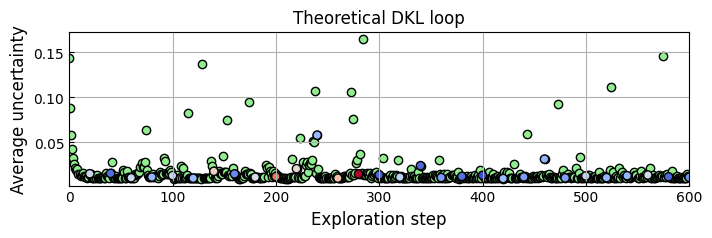

In [45]:
fig, ax = plt.subplots(figsize=(8,2))

ax.scatter(res['ind_th'], dkl_th[:,1], marker='o', c='lightgreen',
              edgecolor='black')
ax.scatter(res['ind_mse'], dkl_th[res['ind_mse'],1], marker='o', c=res['mse'],
              cmap='coolwarm', edgecolor='black')

ax.set_title('Theoretical DKL loop')
ax.set_xlim(0,600)
ax.tick_params('both', direction='in')
ax.grid(True)
ax.set_xlabel('Exploration step', fontsize=12)
ax.set_ylabel('Average uncertainty', fontsize=12)

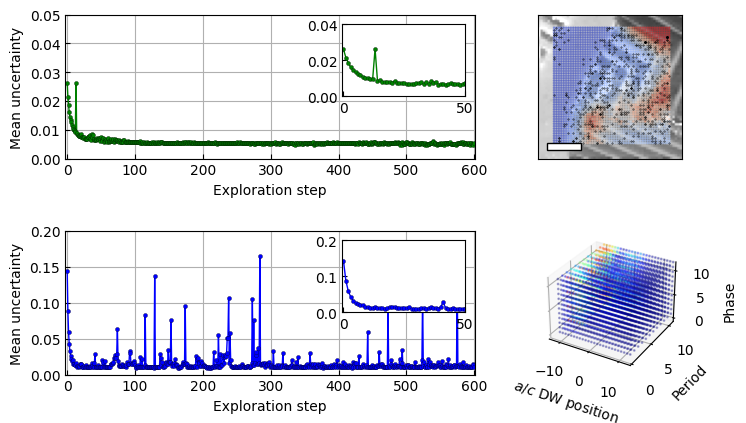

In [46]:
patch_image = pr_mat_ndim1[:60,:60,0]

origin = 0.05*patch_image.shape[0], 0.05*patch_image.shape[1]
length = len(patch_image[0])/4.2
height = length/5


fig = plt.figure(figsize=(6.5, 4), dpi = 100)
fig.subplots_adjust(left=0.05, right=1, bottom=0.05, top=0.95, wspace=0.3)
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[ 4.5, 2.3],
                       height_ratios=[2, 2])

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(res['ind_exp'], dkl_exp[:,1], 'o-', c='green',
              mec='black', mew=0.2, ms=3, lw=1)
ax0.set_ylim(0, 0.05)
ax0.tick_params('both', direction='in')
ax0.set_xlabel('Exploration step', fontsize=10)
ax0.set_ylabel('Mean uncertainty', fontsize=10)

axins = inset_axes(ax0,
                   width="30%",  # width of inset axes
                   height="50%",  # height of inset axes
                   loc='upper right',
                   borderpad=0.7)

axins.plot(res['ind_exp'], dkl_exp[:,1], 'o-', c='green',
              mec='black', mew=0.2, ms=3, lw=1)
axins.set_xlim(-0.5,50)
axins.set_ylim(0,0.04)
axins.tick_params('both', direction='in')

ax1 = fig.add_subplot(gs[1, 0])

ax1.plot(res['ind_th'], dkl_th[:,1], 'o-', c='blue',
            mec='black', mew=0.2, ms=3, lw=1)
ax1.set_ylim(0, 0.2)

axins = inset_axes(ax1,
                   width="30%",  # width of inset axes
                   height="50%",  # height of inset axes
                   loc='upper right',
                   borderpad=0.7)

axins.plot(res['ind_th'], dkl_th[:,1], 'o-', c='blue',
            mec='black', mew=0.2, ms=3, lw=1)
axins.set_xlim(-0.5,50)
axins.set_ylim(0,0.2)
axins.tick_params('both', direction='in')



for _ in [ax0, ax1]:
  _.grid(True)

  _.set_xlim(-3, 601)
  _.set_xlabel('Exploration step', fontsize=10)
  _.set_ylabel('Mean uncertainty', fontsize=10)
  _.tick_params('both', direction='in')


ax_im0 = fig.add_subplot(gs[0, 1])

ax_im0.imshow(pr_mat_ndim1[:60,:60,0], origin='lower',
           vmin=-2.5, vmax=0.5, cmap='gray')

ax_im0.scatter(res['coord_exp'][:,1],
               res['coord_exp'][:,0],
               c = res['dkl_res_exp'][-1,0],
               cmap='coolwarm', alpha=0.5, s=1)

ax_im0.scatter(coords[res['seed_last_step_exp'],1], coords[res['seed_last_step_exp'],0], marker='o', color='black',
              s=0.1)

ax_im0.set_xticks([])
ax_im0.set_yticks([])

ax_im0.add_patch(patches.Rectangle(origin, length, height, color = 'white', ec='k', lw=1, fill = True))


ax_im1 = fig.add_subplot(gs[1, 1], projection='3d')
ax_im1.set_xlabel(r'$a/c$ DW position' )
ax_im1.set_ylim(-.1, 11)
ax_im1.set_yticks([0,5,10], [0,5,10])
ax_im1.set_ylabel('Period')
ax_im1.text2D(0.15, 0, 'Phase', rotation=90, va='center', ha='center')

ax_im1.scatter(res['coord_th'][:,0],
               res['coord_th'][:,1],
               res['coord_th'][:,2],
               c=res['dkl_res_th'][-1,0],
               cmap='jet',
               s=1, alpha=0.3)



fig.subplots_adjust(left=0, right=1, bottom=0.05, top=0.95, wspace=0.1, hspace=0.5)

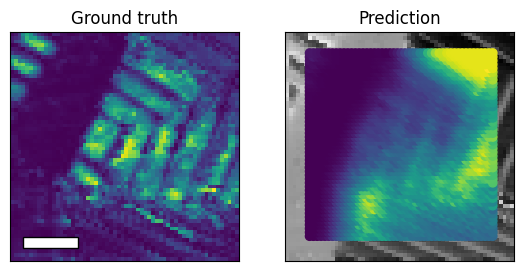

In [47]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3))

ax[0].imshow(areas, origin='lower')
ax[0].set_title('Ground truth')
ax[0].add_patch(patches.Rectangle(origin, length, height, color = 'white', ec='k', lw=1, fill = True))

ax[1].imshow(patch_image, cmap='gray', origin='lower')
ax[1].scatter(res['coord_exp'][:,1],res['coord_exp'][:,0], c=res['dkl_res_exp'][-1,0])
ax[1].set_title('Prediction')


for _ in ax:
  _.set_xticks([])
  _.set_yticks([])

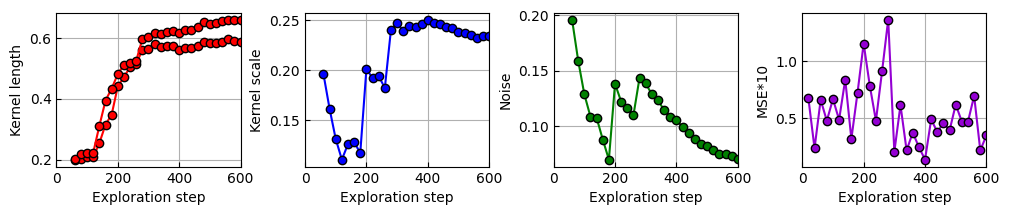

In [50]:
fig, ax = plt.subplots(1,4, figsize=(12,2))
fig.subplots_adjust(wspace=0.35)

ax[0].plot(res['ind_dkl_out'],
           res['dkl_out_klength'],
           'o-', c='r', mec='black')
ax[0].set_ylabel('Kernel length')

ax[1].plot(res['ind_dkl_out'],
           res['dkl_out_kscale'],
           'o-', c='b', mec='black')
ax[1].set_ylabel('Kernel scale')

ax[2].plot(res['ind_dkl_out'],
           res['dkl_out_noise'],
           'o-', c='g', mec='black')
ax[2].set_ylabel('Noise')

ax[3].plot(res['ind_mse'],
           res['mse'],
           'o-', c='darkviolet', mec='black')
ax[3].set_ylabel('MSE*10')

for _ in ax:
  _.set_xlim(0,600)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')


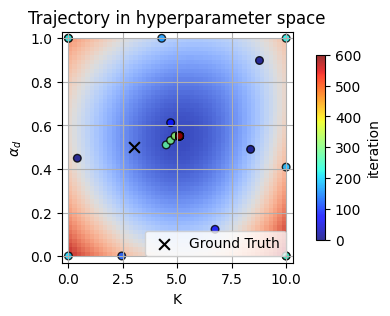

In [51]:
coord_out = res['coord_out']
seeds_out = res['seed_last_step_out']

cc = np.zeros(len(seeds_out))
cc[-len(res['ind_dkl_out']):] = res['ind_dkl_out']

fig,ax = plt.subplots(figsize=(6,3))
ax.imshow(res['dkl_res_out'][-1][0].reshape(50,50).T, extent=(0,10,0,1), origin='lower', cmap='coolwarm')
ax.set_aspect(10)

im= ax.scatter(coord_out[seeds_out][:,0]*10,
               coord_out[seeds_out][:,1],
               c=cc, s=30, alpha=0.8,
               cmap='jet', edgecolor='black')

ax.scatter(0.3*10,
           0.5,
           marker= 'x',
           s=60,
           c= 'black',
           label = 'Ground Truth')

fig.colorbar(im, label='iteration', shrink=0.8)

ax.set_title('Trajectory in hyperparameter space')
ax.set_xlabel('K')
ax.set_ylabel(r"$\alpha_{d}$")
ax.set_xlim(-0.3,10.3)
ax.set_ylim(-0.03,1.03)
ax.grid()
ax.legend(loc='lower right')

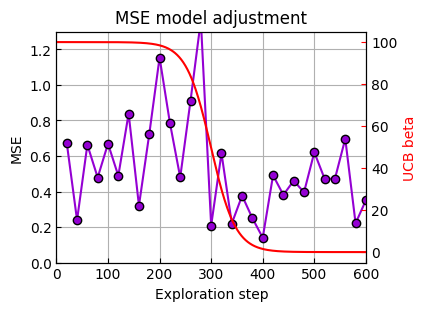

In [60]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(res['ind_mse'], res['mse'], 'o-', c='darkviolet', mec='black')

ax.set_title('MSE model adjustment')

ax1 = ax.twinx()
ax1.plot(beta_sequence, c='r')
ax1.set_ylabel('UCB beta', c='r')
ax1.tick_params('both', color='r', direction='in')

for _ in [ax,]:
  _.set_xlim(0,601)
  _.set_ylim(0,1.3)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')
  _.set_ylabel('MSE')

In [56]:
dif_coord = coord_out[seeds_out][1:] - coord_out[seeds_out][:-1]
dist_coord = abs(dif_coord[:,0] - dif_coord[:,1])

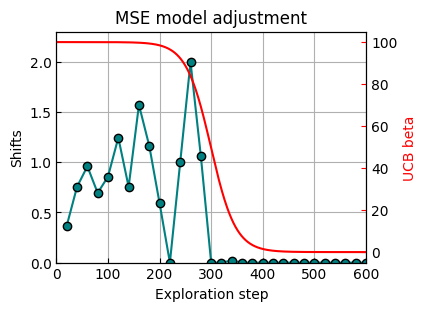

In [61]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(res['ind_mse'], dist_coord, 'o-', c='teal', mec='black')
ax.set_title('MSE model adjustment')
ax1 = ax.twinx()
ax1.plot(beta_sequence, c='r')
ax1.set_ylabel('UCB beta', c='r')
ax1.tick_params('both', color='r', direction='in')

for _ in [ax,]:
  _.set_xlim(0,601)
  _.set_ylim(0,2.3)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')
  _.set_ylabel('Shifts')

## Ground truth for several patches

In [ ]:
indexes = [240, 590, 1900, 2800]

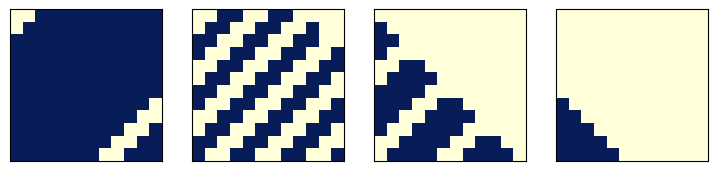

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(9, 2))

for i in range(len(ax)):
  ax[i].imshow(X[indexes[i]], cmap='YlGnBu')
  ax[i].set_xticks([])
  ax[i].set_yticks([])

In [ ]:
lambda_y = lambda x, coupl, a_dep: ferrosim_calc(x,
                                                gamma = 100,
                                                defect_field = (30,0),
                                                c_const = coupl*10,
                                                Eamp = (1E-9, 2),
                                                time_vec_length = 5000,
                                                dep_alpha = a_dep)

dep_alpha = np.linspace(0.001,1,20)
coupl_c  = np.linspace(0.001,1,20)

gt_arrays = []

for k in range(len(indexes)):
  gt_array1 = np.zeros([20,20])
  inds = indexes[k]

  for i in range(20):
    for j in range(20):
      next_loop = lambda_y(X[inds], coupl_c[j], dep_alpha[i])
      gt_array1[i,j] = get_area(next_loop[0][1, len(next_loop[0])//2:],
                              next_loop[1][1, len(next_loop[0])//2:])
  gt_arrays.append(gt_array1)


In [ ]:
gt_res = {'ind': indexes,
          'X': X,
          'gt_arrays': gt_arrays}

In [ ]:
save_dict_to_hdf5('gt_res.h5', gt_res)

In [ ]:
def plot_ax(axx, gt_array1, ind):
  axx.contourf(np.linspace(0,10,20),
              np.linspace(0,1,20),
              abs(gt_array1 - gt_array1[10,6]),
              30,
              vmax=120,
              vmin=0,
              origin='lower', cmap='coolwarm')
  axx.set_aspect(10)
  axx.tick_params('both', direction='in')

  axx.scatter(x=3, y=0.5, marker='x', c='white')

  axins = inset_axes(axx,
                      width="30%",  # width of inset axes
                      height="30%",  # height of inset axes
                      loc='upper right')
  axins.set_xticks([])
  axins.set_yticks([])
  im = axins.imshow(~X[ind], cmap='YlGnBu',
                      interpolation='nearest',
                      vmin=0, vmax=1, origin='lower')
  return axx

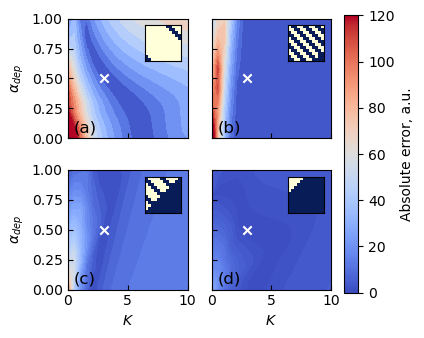

In [ ]:
from matplotlib.cm import ScalarMappable
letters = ['(a)', '(b)', '(c)', '(d)']
fig,ax = plt.subplots(2,2, figsize=(4.2,3.6), sharex=True, sharey=True)

plot_ax(ax[0,0], gt_arrays[0], indexes[0])
plot_ax(ax[0,1], gt_arrays[1], indexes[1])
plot_ax(ax[1,0], gt_arrays[2], indexes[2])
plot_ax(ax[1,1], gt_arrays[3], indexes[3])

for _ in ax[1]:
    _.set_xlabel(r'$K$')

for _ in ax[:,0]:
   _.set_ylabel(r'$\alpha_{dep}$')

for i, _ in enumerate(ax.flatten()):
  _.text(0.5, 0.05, s=letters[i], fontsize=12, color='black')

sm = ScalarMappable(cmap='coolwarm')
sm.set_array([0,120])

cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', pad=0.04)
cbar.set_label('Absolute error, a.u.')

In [ ]:
abs(gt_arrays[3] - gt_arrays[3][10,6]).max()

31.159857842740166

## Two exp graphs

In [62]:
norm_res   = trajectory_forensic('/content/1_th_th_standard.h5')
struct_res = trajectory_forensic('/content/2_th_th_structural.h5')

In [63]:
coords_norm   = norm_res['coord_out'][norm_res['seed_last_step_out']]
coords_struct = struct_res['coord_out'][struct_res['seed_last_step_out']]

dif_coord_norm  = coords_norm[1:] - coords_norm[:-1]
dist_coord_norm = (dif_coord_norm[:,0]**2 + dif_coord_norm[:,1]**2)**0.5

dif_coord_struct  = coords_struct[1:] - coords_struct[:-1]
dist_coord_struct = (dif_coord_struct[:,0]**2 + dif_coord_struct[:,1]**2)**0.5

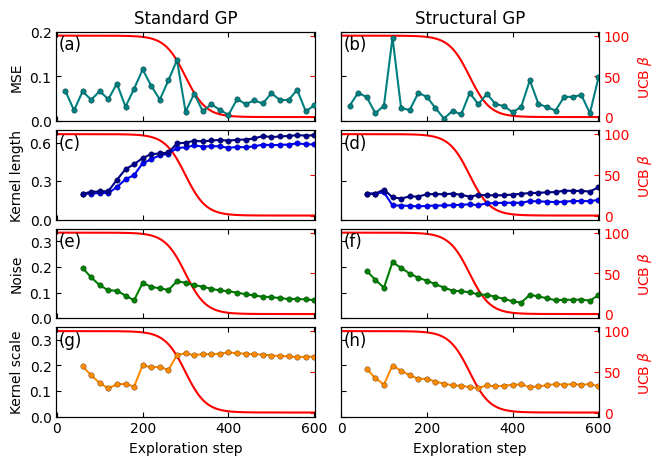

In [65]:
#@title fig for article: GP params evolution
import string
letters = [letter for letter in string.ascii_lowercase[:8]]

fig, ax = plt.subplots(4,2, figsize=(7,5), sharex=True, sharey=False, dpi=100)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

#MSE
ax[0,0].plot(norm_res['ind_mse'],
              norm_res['mse']/10,
              'o-', c='teal', mec='black',
              ms=4, mew=0.2, zorder=5)
ax[0,0].set_ylabel('MSE')

ax[0,1].plot(struct_res['ind_mse'],
             struct_res['mse']/10,
              'o-', c='teal', mec='black',
              ms=4, mew=0.2)

#kernel length
ax[1,0].plot(norm_res['ind_dkl_out'],
             norm_res['dkl_out_klength'][:,0],
            'o-', c='blue', mec='black',
             ms=4, mew=0.2)
ax[1,0].plot(norm_res['ind_dkl_out'],
             norm_res['dkl_out_klength'][:,1],
             'o-', c='darkblue', mec='black',
             ms=4, mew=0.2)
ax[1,0].set_ylabel('Kernel length')

ax[1,1].plot(struct_res['ind_dkl_out'],
             struct_res['dkl_out_klength'][:,0],
             'o-', c='blue', mec='black',
             ms=4, mew=0.2)
ax[1,1].plot(struct_res['ind_dkl_out'],
             struct_res['dkl_out_klength'][:,1],
             'o-', c='darkblue', mec='black',
             ms=4, mew=0.2)

#noise
ax[2,0].plot(norm_res['ind_dkl_out'],
             norm_res['dkl_out_noise'],
             'o-', c='green', mec='black',
             ms=4, mew=0.2)
ax[2,0].set_ylabel('Noise')

ax[2,1].plot(struct_res['ind_dkl_out'],
             struct_res['dkl_out_noise'],
             'o-', c='green', mec='black',
             ms=4, mew=0.2)

#Kernel scale
ax[3,0].plot(norm_res['ind_dkl_out'],
             norm_res['dkl_out_kscale'],
             'o-', c='darkorange', mec='black',
             ms=4, mew=0.2)
ax[3,0].set_ylabel('Kernel scale')

ax[3,1].plot(struct_res['ind_dkl_out'],
             struct_res['dkl_out_kscale'],
             'o-', c='darkorange', mec='black',
             ms=4, mew=0.2)

#Params
ax[0,0].set_title('Standard GP')
ax[0,1].set_title('Structural GP')
ax[3,0].set_xlabel('Exploration step')
ax[3,1].set_xlabel('Exploration step')

for _ in ax.flat:
  _.tick_params('both', direction='in', top=True)
  _.set_xlim(-1,601)
  _.set_zorder(1)
  _.set_facecolor('none')

for _ in ax[:,1]:
  _.set_yticklabels([])

for _ in ax[0]:
  _.set_ylim(0,0.2)

for _ in ax[1]:
  _.set_ylim(0,0.7)
  _.set_yticks([0,0.3,0.6])

for _ in ax[2:4].flat:
  _.set_ylim(0,0.35)
  _.set_yticks([0,0.1,0.2,0.3])

for i, _ in enumerate(ax.flat):
  lims = _.get_ylim()
  _.text(5, lims[1]-0.2*lims[1], f'({letters[i]})', fontsize=12)

  axx = _.twinx()
  axx.plot(beta_sequence, c='r')
  axx.tick_params('both', color='r', direction='in')
  axx.set_zorder(0)

  if  (i+1) % 2 == 0:
    axx.set_ylabel(r'UCB $\beta$', c='r')
    axx.set_yticks([0,50,100])
    axx.set_yticklabels([0,50,100], c='r')
  if  (i+1) % 2 != 0:
    axx.set_yticklabels([])

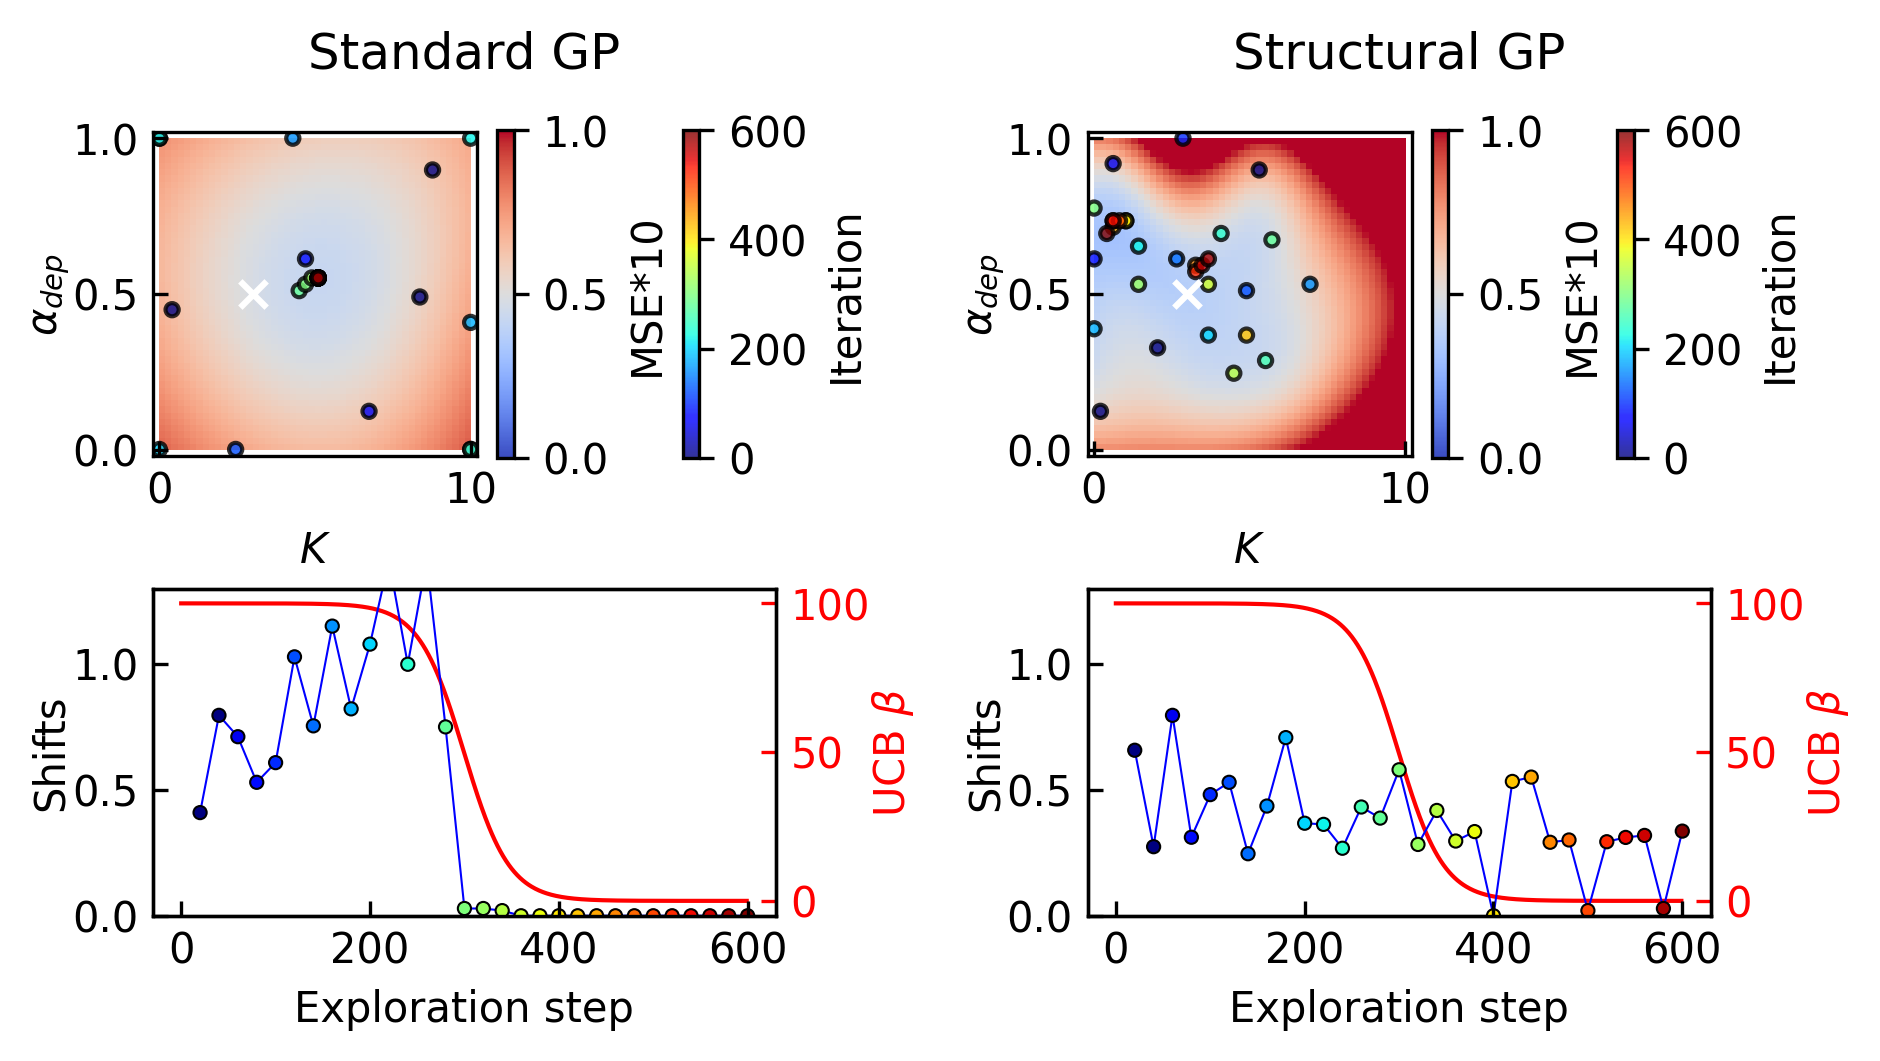

In [66]:
#@title figure for article: exploration of the latent space
cc = np.zeros(len(coords_norm))
cc[-len(norm_res['ind_dkl_out']):] = norm_res['ind_dkl_out']

cc_struct = np.zeros(len(coords_struct))
cc_struct[-len(struct_res['ind_dkl_out']):] = struct_res['ind_dkl_out']

norm_dkl = norm_res['dkl_res_out'][-1][0]
struct_dkl = struct_res['dkl_res_out'][-1][0]



fig, ax = plt.subplots(2,2, figsize=(6.7,3.4), dpi=300)
fig.subplots_adjust(wspace=0.5, hspace=0.4)

#ax[0,0]
im0 = ax[0,0].imshow(norm_dkl.reshape(int(len(norm_dkl)**0.5),
                                int(len(norm_dkl)**0.5)).T,
                     extent=(0,10,0,1),
                     origin='lower',
                     cmap='coolwarm',
                     vmin=0,
                     vmax=1)
ax[0,0].set_aspect(10)

im_sc= ax[0,0].scatter(coords_norm[:,0]*10,
                       coords_norm[:,1],
                       c=cc, s=10, alpha=0.8,
                       cmap='jet', edgecolor='black',)
ax[0,0].set_xlim(-0.2, 10.2)
ax[0,0].set_ylim(-0.02, 1.02)

cbar_sc = fig.colorbar(im_sc, ax=ax[0,0], pad=0.2)
cbar_sc.set_label('Iteration')
cbar = fig.colorbar(im0, ax=ax[0,0], pad=0.05)
cbar.set_label('MSE*10')

#ax[0,1]
im1 = ax[0,1].imshow(struct_dkl.reshape(int(len(struct_dkl)**0.5),
                                        int(len(struct_dkl)**0.5)).T,
                     extent=(0,10,0,1),
                     origin='lower',
                     cmap='coolwarm',
                     vmin=0,
                     vmax=1)
ax[0,1].set_aspect(10)

im_sc1= ax[0,1].scatter(coords_struct[:,0]*10,
                        coords_struct[:,1],
                        c=cc_struct, s=10, alpha=0.8,
                        cmap='jet', edgecolor='black',)
ax[0,1].set_xlim(-0.2, 10.2)
ax[0,1].set_ylim(-0.02, 1.02)


cbar_sc = fig.colorbar(im_sc, ax=ax[0,1], pad=0.2)
cbar_sc.set_label('Iteration')
cbar = fig.colorbar(im1, ax=ax[0,1], pad=0.05)
cbar.set_label('MSE*10')

#parameter shift
ax[1,0].plot(norm_res['ind_mse'],
             dist_coord_norm,
             zorder=0,
             lw=0.5,
             c='b')
ax[1,0].scatter(norm_res['ind_mse'],
                dist_coord_norm,
                marker='o',
                c=cc[1:],
                cmap='jet',
                s=10,
                ec='black',
                lw=0.5,
                zorder=1)

ax[1,1].plot(struct_res['ind_mse'],
             dist_coord_struct,
             zorder=0,
             lw=0.5,
             c='b')
ax[1,1].scatter(struct_res['ind_mse'],
                dist_coord_struct,
                marker='o',
                c=cc[1:],
                cmap='jet',
                s=10,
                ec='black',
                lw=0.5,
                zorder=1)

ax[1,0].set_title('Standard GP', pad=125)
ax[1,1].set_title('Structural GP', pad=125)

for _ in ax[1]:
  _.set_ylabel('Shifts', labelpad=0.01)
  _.set_xlabel('Exploration step')
  _.set_ylim(0,1.3)
  _.set_zorder(1)
  _.set_facecolor('none')
  axx = _.twinx()
  axx.plot(beta_sequence, c='r', lw=1)
  axx.tick_params('both', color='r', direction='in')
  axx.set_ylabel(r'UCB $\beta$', c='r', labelpad=0)
  axx.set_yticks([0,50,100])
  axx.set_yticklabels([0,50,100], c='r')
  axx.set_zorder(_.get_zorder() - 1)


for _ in ax[0]:
  _.set_xlabel(r'$K$')
  _.set_ylabel(r'$\alpha_{dep}$', labelpad=0.01)
  _.scatter(0.3*10,
           0.5,
           marker= 'x',
           s=40,
           c= 'white',
           label = 'Ground Truth')

for _ in ax.flat:
  _.tick_params('both', direction='in')